### Import necessary packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, accuracy_score
import time
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
import pickle
from sklearn.utils.class_weight import compute_sample_weight

### Read the CSV File

In [ ]:
data = pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression='gzip')
data.head()

/tmp/ipykernel_2083216/3032114091.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression='gzip')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


### Exploratory Data Analysis

In [ ]:
# Select only object (string) columns
string_cols = data.select_dtypes(include=['object']).columns

# Find columns where any row contains '%'
cols_with_percent = [col for col in string_cols if data[col].astype(str).str.contains('%', na=False).any()]

# Print the result
print(cols_with_percent)
print(string_cols)

['emp_title', 'desc', 'title']
Index(['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint', 'sec_app_earliest_cr_line',
       'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')


In [ ]:
for d in data.columns:
    print(d)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
to

In [ ]:
data['loan_status'].value_counts(normalize=True)*100

loan_status
Fully Paid                                             47.629771
Current                                                38.852100
Charged Off                                            11.879630
Late (31-120 days)                                      0.949587
In Grace Period                                         0.373164
Late (16-30 days)                                       0.192377
Does not meet the credit policy. Status:Fully Paid      0.087939
Does not meet the credit policy. Status:Charged Off     0.033663
Default                                                 0.001769
Name: proportion, dtype: float64

In [ ]:
data['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [ ]:
data['issue_d'].value_counts()

issue_d
Mar-2016    61992
Oct-2015    48631
May-2018    46311
Oct-2018    46305
Aug-2018    46079
            ...  
Aug-2007       74
Jul-2007       63
Sep-2008       57
Sep-2007       53
Jun-2007       24
Name: count, Length: 139, dtype: int64

In [ ]:
data['Date'] = pd.to_datetime(data['issue_d'], format="%b-%Y")
data['Year'] = data['Date'].dt.year

In [ ]:
print("Missing Values:")
missing_data = data.isnull().sum()
missing_percentage = (missing_data / len(data)) * 100
missing_df = pd.DataFrame({
    'Attributes': data.columns,
    'Missing Values': missing_data,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0])

Missing Values:
                                  Attributes  Missing Values  Percentage
member_id                          member_id         2260701   100.00000
loan_amnt                          loan_amnt              33     0.00146
funded_amnt                      funded_amnt              33     0.00146
funded_amnt_inv              funded_amnt_inv              33     0.00146
term                                    term              33     0.00146
...                                      ...             ...         ...
settlement_amount          settlement_amount         2226455    98.48516
settlement_percentage  settlement_percentage         2226455    98.48516
settlement_term              settlement_term         2226455    98.48516
Date                                    Date              33     0.00146
Year                                    Year              33     0.00146

[152 rows x 3 columns]


In [ ]:
attributes = []
for i in missing_df.Attributes:
    attributes.append(i)

In [ ]:
missing_percentages = []
for i in missing_percentage:
    missing_percentages.append(i)

In [ ]:
m_attr = []
m_percent = []
for i in range(len(attributes)):
    if missing_percentages[i] > 50:
        m_attr.append(attributes[i])
        m_percent.append(missing_percentages[i])

In [ ]:
m_attr_50 = []
m_percent_50 = []
for i in range(len(attributes)):
    if missing_percentages[i] <= 50 and missing_percentages[i] > 15:
        m_attr_50.append(attributes[i])
        m_percent_50.append(missing_percentages[i])

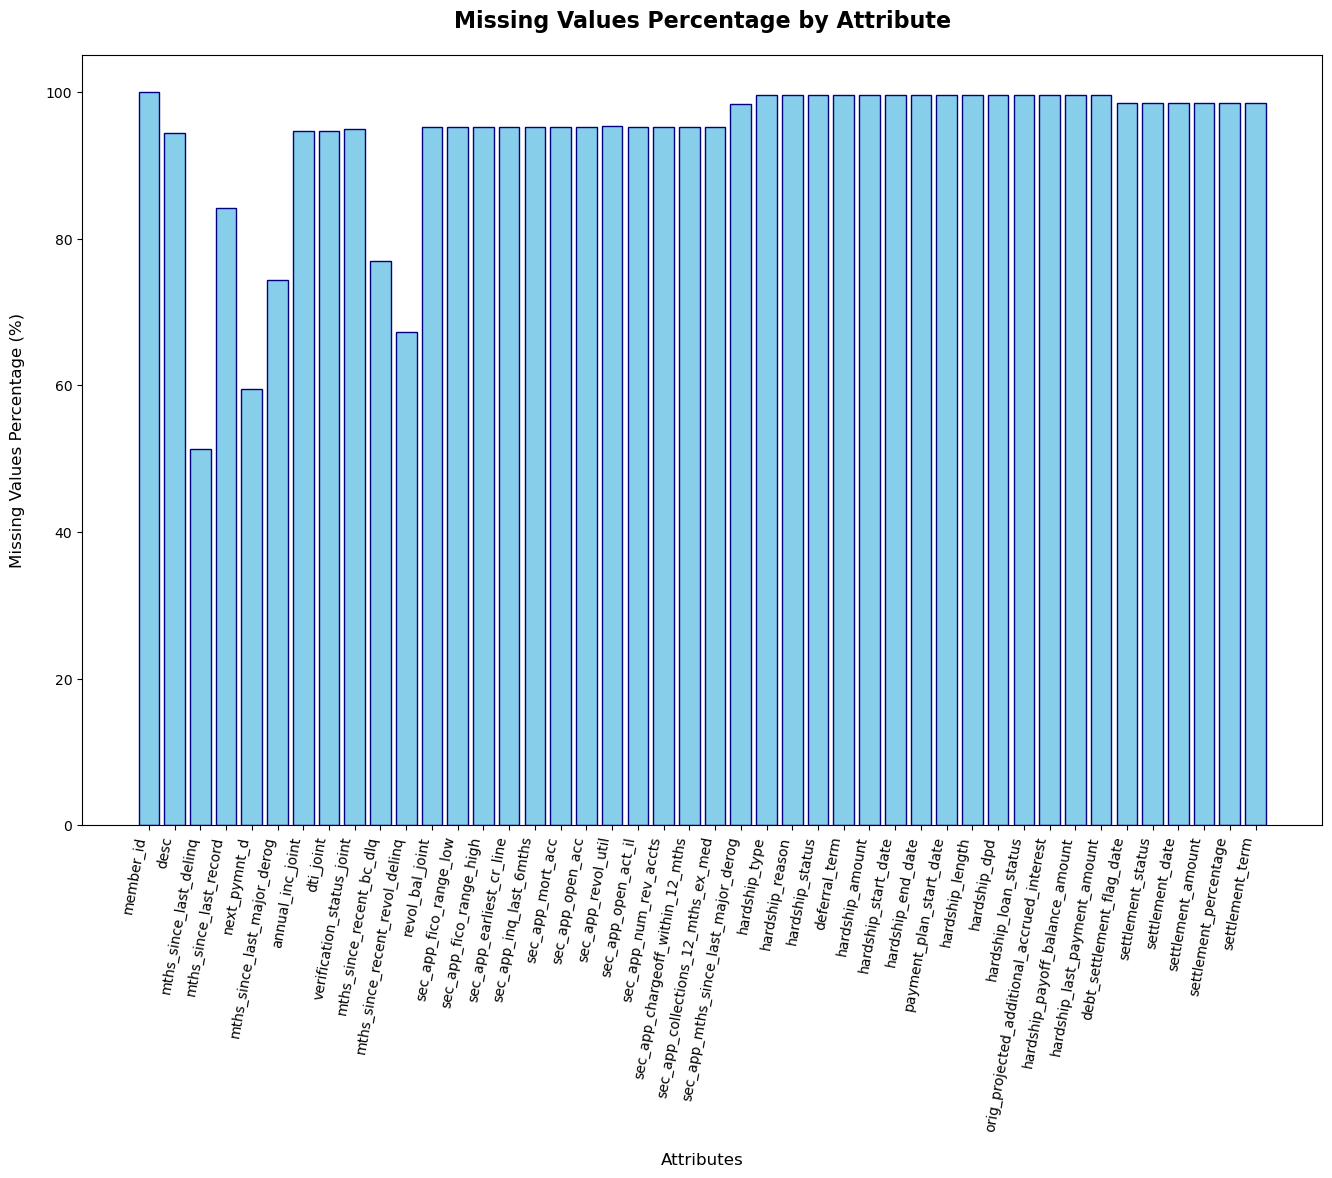

In [ ]:
plt.figure(figsize=(16, 10))
bars = plt.bar(m_attr, m_percent, color='skyblue', edgecolor='navy')
plt.title('Missing Values Percentage by Attribute', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Attributes', fontsize=12, labelpad=15)
# Tilt the x-axis labels (rotate 45 degrees and align to the right)
plt.xticks(rotation=80, ha='right', fontsize=10)
plt.ylabel('Missing Values Percentage (%)', fontsize=12, labelpad=15)
plt.show()

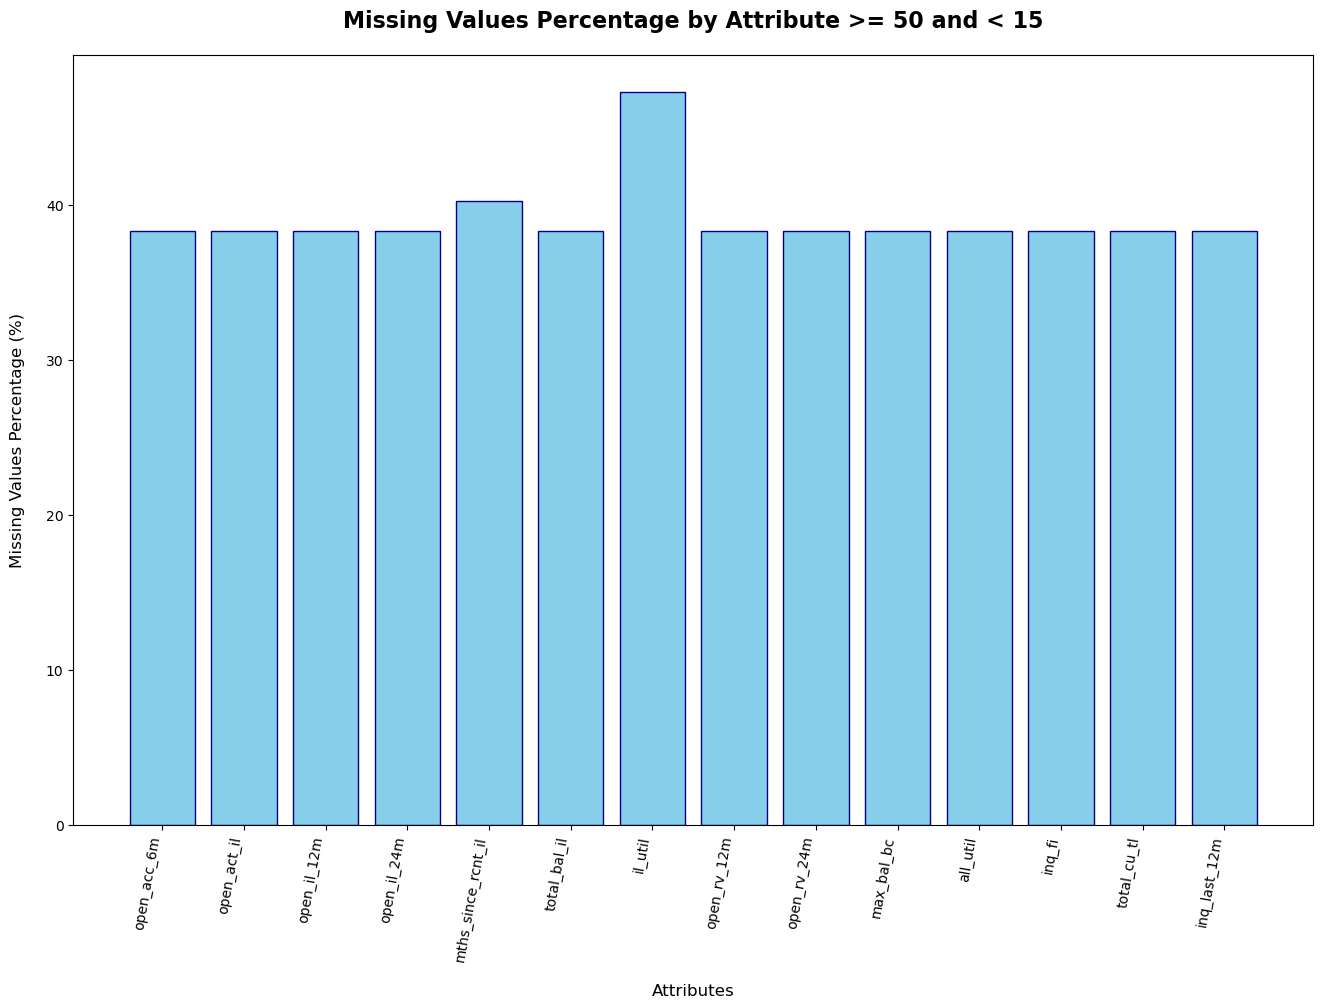

In [ ]:
plt.figure(figsize=(16, 10))
bars = plt.bar(m_attr_50, m_percent_50, color='skyblue', edgecolor='navy')
plt.title('Missing Values Percentage by Attribute >= 50 and < 15', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Attributes', fontsize=12, labelpad=15)
# Tilt the x-axis labels (rotate 45 degrees and align to the right)
plt.xticks(rotation=80, ha='right', fontsize=10)
plt.ylabel('Missing Values Percentage (%)', fontsize=12, labelpad=15)
plt.show()

In [ ]:
# Dropping all the attriutes where more than 50% values are missing
data_dropped = data.drop(m_attr,axis=1)
data_dropped

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,Date,Year
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,2015-12-01,2015.0
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,2015-12-01,2015.0
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,2015-12-01,2015.0
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,...,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N,2015-12-01,2015.0
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,2015-12-01,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,Vice President,...,0.0,55970.0,28398.0,12300.0,42670.0,N,Cash,N,2016-10-01,2016.0
2260697,88224441,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,Program Manager,...,0.0,84664.0,62426.0,20700.0,58764.0,N,Cash,Y,2016-10-01,2016.0
2260698,88215728,14000.0,14000.0,14000.0,60 months,14.49,329.33,C,C4,Customer Service Technician,...,0.0,163804.0,44215.0,9500.0,34169.0,N,Cash,N,2016-10-01,2016.0
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [ ]:
data_dropped['disbursement_method'].value_counts()

disbursement_method
Cash         2182546
DirectPay      78122
Name: count, dtype: int64

In [ ]:
string_cols = data_dropped.select_dtypes(include=['object']).columns
string_cols

Index(['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')

In [ ]:
data_dropped['emp_length'].value_counts()

emp_length
10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: count, dtype: int64

In [ ]:
data_dropped['home_ownership'].value_counts(), data_dropped['home_ownership'].isnull().sum()

(home_ownership
 MORTGAGE    1111450
 RENT         894929
 OWN          253057
 ANY             996
 OTHER           182
 NONE             54
 Name: count, dtype: int64,
 np.int64(33))

/tmp/ipykernel_2083216/1442326925.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


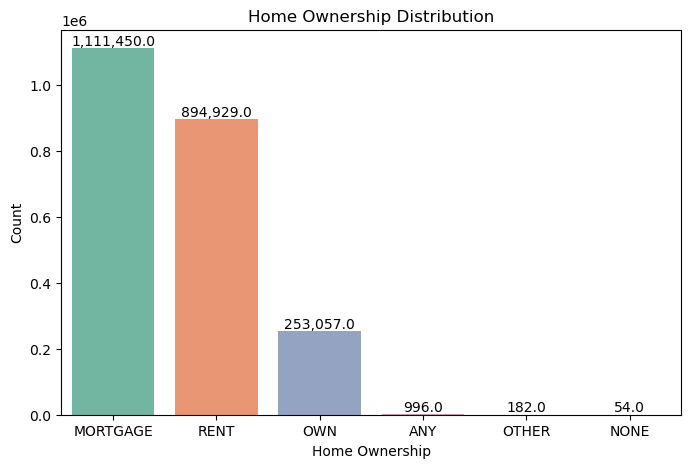

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(
    x='home_ownership',
    data=data_dropped,
    order=data_dropped['home_ownership'].value_counts().index,
    palette="Set2"
)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.title("Home Ownership Distribution")
plt.xlabel("Home Ownership")
plt.ylabel("Count")
plt.show()

In [ ]:
data_dropped['verification_status'].value_counts(), data_dropped['verification_status'].isnull().sum()

(verification_status
 Source Verified    886231
 Not Verified       744806
 Verified           629631
 Name: count, dtype: int64,
 np.int64(33))

/tmp/ipykernel_2083216/1616099007.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


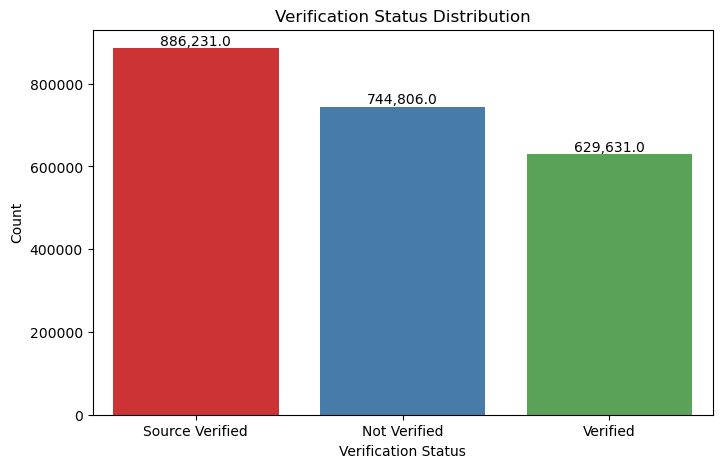

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(
    x='verification_status',
    data=data_dropped,
    order=data_dropped['verification_status'].value_counts().index,
    palette="Set1"
)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.title("Verification Status Distribution")
plt.xlabel("Verification Status")
plt.ylabel("Count")
plt.show()

In [ ]:
data_dropped['pymnt_plan'].value_counts()

pymnt_plan
n    2260048
y        620
Name: count, dtype: int64

In [ ]:
data_dropped['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [ ]:
data_dropped['loan_status'].isnull().value_counts()

loan_status
False    2260668
True          33
Name: count, dtype: int64

In [ ]:
df = data_dropped.copy()

status_map = {
    "Fully Paid": 0,
    "Does not meet the credit policy. Status:Fully Paid": 0,
    #"In Grace Period": 0,
    #"Current": 0,
    "Charged Off": 1,
    "Late (31-120 days)": 1,
    "Late (16-30 days)": 1,
    "Default": 1,
    "Does not meet the credit policy. Status:Charged Off": 1
}
df["loan_status_bin"] = df["loan_status"].map(status_map)
df = df.dropna(subset=["loan_status_bin"])
df["loan_status_bin"] = df["loan_status_bin"].astype(int)
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title',
       ...
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag', 'Date', 'Year', 'loan_status_bin'],
      dtype='object', length=110)

/tmp/ipykernel_2083216/2048167354.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="loan_status_bin", data=df, palette=colors)


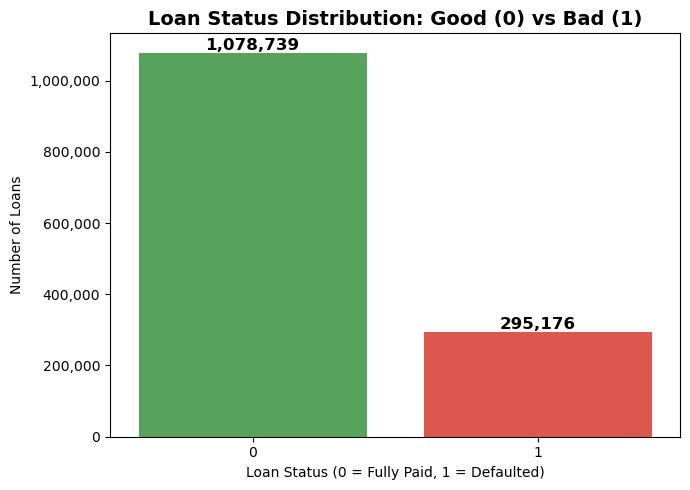

In [ ]:
colors = ["#4CAF50", "#F44336"]
plt.figure(figsize=(7,5))
ax = sns.countplot(x="loan_status_bin", data=df, palette=colors)
plt.title("Loan Status Distribution: Good (0) vs Bad (1)", fontsize=14, weight="bold")
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12, weight='bold')

plt.xlabel("Loan Status (0 = Fully Paid, 1 = Defaulted)")
plt.ylabel("Number of Loans")
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop('loan_status',axis=1)

In [ ]:
for i in df.columns:
    print(i)

id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
pymnt_plan
url
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
fico_range_low
fico_range_high
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
last_credit_pull_d
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
policy_code
application_type
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt

In [ ]:
df['addr_state'].value_counts(), df['addr_state'].isnull().sum()

(addr_state
 CA    200472
 NY    112564
 TX    112563
 FL     98019
 IL     52715
 NJ     49525
 PA     46532
 OH     44606
 GA     44303
 VA     38857
 NC     38573
 MI     35936
 AZ     33326
 MD     32040
 MA     31628
 CO     30156
 WA     29680
 MN     24418
 IN     22131
 MO     21768
 TN     20794
 NV     20634
 CT     20188
 WI     18171
 AL     17014
 OR     16654
 SC     16295
 LA     15835
 KY     13102
 OK     12564
 KS     11432
 AR     10279
 UT     10202
 NM      7510
 HI      6888
 MS      6834
 NH      6583
 RI      5987
 WV      4936
 MT      3887
 DE      3867
 NE      3695
 DC      3532
 AK      3257
 WY      2967
 SD      2814
 VT      2701
 ME      2070
 ID      1744
 ND      1653
 IA        14
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
state_to_region = {
    # Northeast
    'CT':'E','ME':'E','MA':'E','NH':'E','RI':'E','VT':'E',
    'NJ':'E','NY':'E','PA':'E',

    # Midwest
    'IL':'N','IN':'N','MI':'N','OH':'N','WI':'N',
    'IA':'N','KS':'N','MN':'N','MO':'N','NE':'N','ND':'N','SD':'N',

    # South
    'DE':'S','FL':'S','GA':'S','MD':'S','NC':'S','SC':'S','VA':'S','WV':'S','DC':'S',
    'AL':'S','KY':'S','MS':'S','TN':'S',
    'AR':'S','LA':'S','OK':'S','TX':'S',

    # West
    'AZ':'W','CO':'W','ID':'W','MT':'W','NV':'W','NM':'W','UT':'W','WY':'W',
    'AK':'W','CA':'W','HI':'W','OR':'W','WA':'W'
}


df['region'] = df['addr_state'].map(state_to_region)
df['region'].value_counts()

region
S    489407
W    367377
E    277778
N    239353
Name: count, dtype: int64

/tmp/ipykernel_2083216/4122356395.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


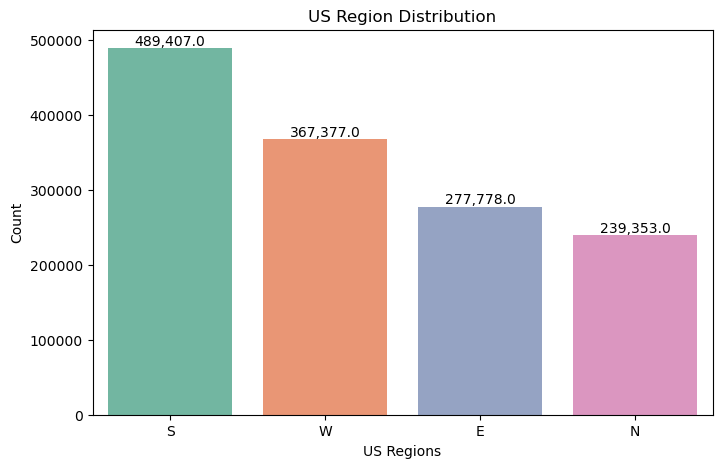

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(
    x='region',
    data=df,
    order=df['region'].value_counts().index,
    palette="Set2"
)
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():,}',                # format with commas
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.title("US Region Distribution")
plt.xlabel("US Regions")
plt.ylabel("Count")
plt.show()

In [ ]:
encoder = LabelEncoder()
numeric = encoder.fit_transform(df['region'])
numeric[:5]

array([0, 1, 1, 0, 2])

In [ ]:
df['region'] = numeric
df['region'].value_counts()

region
2    489407
3    367377
0    277778
1    239353
Name: count, dtype: int64

In [ ]:
df['purpose'].value_counts(), df['purpose'].isnull().sum()

(purpose
 debt_consolidation    796439
 credit_card           300459
 home_improvement       89487
 other                  80215
 major_purchase         30225
 small_business         15987
 medical                15957
 car                    14874
 moving                  9747
 vacation                9271
 house                   7527
 wedding                 2350
 renewable_energy         954
 educational              423
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
# Financial: 0, Personal: 1, misc: 2
purpose_bins = {
    "debt_consolidation": 0,
    "credit_card": 0,
    "home_improvement": 1,
    "other": 2,
    "major_purchase": 2,
    "medical": 1,
    "small_business": 2,
    "car": 1,
    "vacation": 1,
    "moving": 1,
    "house": 1,
    "wedding": 1,
    "renewable_energy": 2,
    "educational": 1
}

In [ ]:
df['purpose'] =  df['purpose'].map(purpose_bins)
df['purpose'].value_counts()

purpose
0    1096898
1     149636
2     127381
Name: count, dtype: int64

In [ ]:
df['initial_list_status'].value_counts(), df['initial_list_status'].isnull().sum()

(initial_list_status
 w    804303
 f    569612
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['initial_list_status'] = encoder.fit_transform(df['initial_list_status'])
df['initial_list_status'].value_counts()

initial_list_status
1    804303
0    569612
Name: count, dtype: int64

In [ ]:
df['application_type'].value_counts(), df['application_type'].isnull().sum()

(application_type
 Individual    1345425
 Joint App       28490
 Name: count, dtype: int64,
 np.int64(0))

/tmp/ipykernel_2083216/3049095757.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


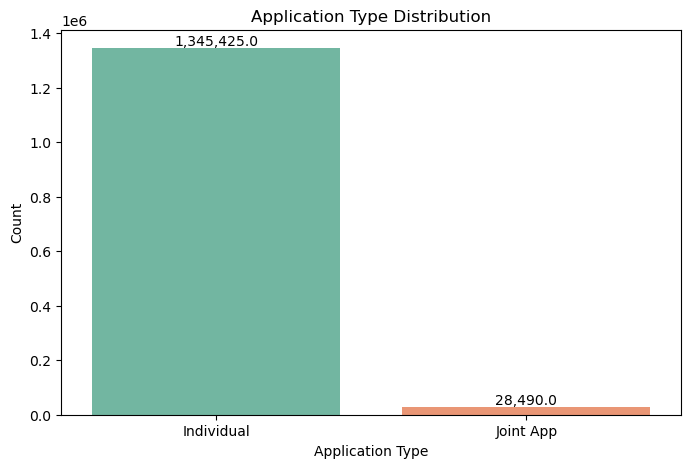

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(
    x='application_type',
    data=df,
    order=df['application_type'].value_counts().index,
    palette="Set2"
)
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():,}',                # format with commas
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.title("Application Type Distribution")
plt.xlabel("Application Type")
plt.ylabel("Count")
plt.show()

In [ ]:
df['application_type'] = encoder.fit_transform(df['application_type'])
df['application_type'].value_counts()

application_type
0    1345425
1      28490
Name: count, dtype: int64

In [ ]:
df['grade'].value_counts(), df['grade'].isnull().sum()

(grade
 B    398883
 C    391353
 A    236856
 D    207387
 E     96760
 F     33075
 G      9601
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
numeric = encoder.fit_transform(df['grade'])
numeric[:5]

array([2, 2, 1, 5, 2])

In [ ]:
df = df.drop('grade',axis=1)

In [ ]:
df['debt_settlement_flag'].value_counts(), df['debt_settlement_flag'].isnull().sum()

(debt_settlement_flag
 N    1339707
 Y      34208
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['debt_settlement_flag'] = encoder.fit_transform(df['debt_settlement_flag'])
df['debt_settlement_flag'].value_counts()

debt_settlement_flag
0    1339707
1      34208
Name: count, dtype: int64

In [ ]:
df['disbursement_method'].value_counts(), df['disbursement_method'].isnull().sum()

(disbursement_method
 Cash         1366323
 DirectPay       7592
 Name: count, dtype: int64,
 np.int64(0))

/tmp/ipykernel_2083216/69250615.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


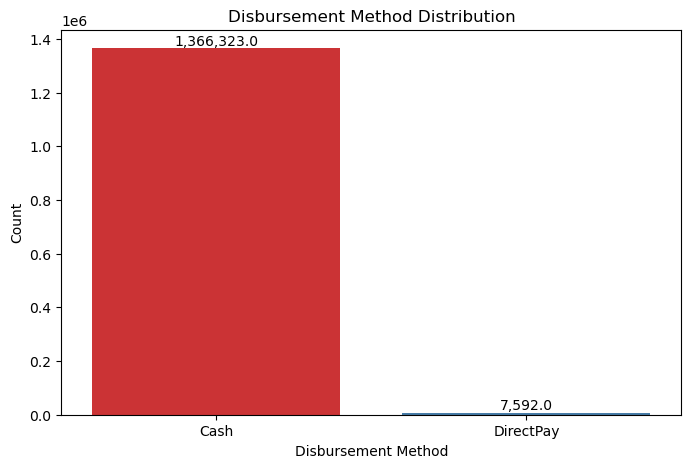

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(
    x='disbursement_method',
    data=df,
    order=df['disbursement_method'].value_counts().index,
    palette="Set1"
)
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.title("Disbursement Method Distribution")
plt.xlabel("Disbursement Method")
plt.ylabel("Count")
plt.show()

In [ ]:
df['disbursement_method'] = encoder.fit_transform(df['disbursement_method'])
df['disbursement_method'].value_counts()

disbursement_method
0    1366323
1       7592
Name: count, dtype: int64

In [ ]:
df.select_dtypes(include=['object']).columns

Index(['id', 'term', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'title',
       'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d',
       'last_credit_pull_d', 'hardship_flag'],
      dtype='object')

In [ ]:
df['sub_grade'].value_counts(), df['sub_grade'].isnull().sum()

(sub_grade
 C1    87266
 B4    84609
 B5    84238
 B3    82948
 C2    80990
 C3    76869
 C4    76557
 B2    75014
 B1    72074
 C5    69671
 A5    64562
 D1    52748
 A4    52684
 D2    46157
 A1    43869
 D3    40696
 A3    38310
 A2    37431
 D4    36752
 D5    31034
 E1    24383
 E2    21990
 E3    19056
 E4    16261
 E5    15070
 F1    10269
 F2     7401
 F3     6282
 F4     5019
 F5     4104
 G1     3127
 G2     2207
 G3     1685
 G4     1368
 G5     1214
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['home_ownership'] = encoder.fit_transform(df['home_ownership'])
df['home_ownership'].value_counts(), df['home_ownership'].isnull().sum()

(home_ownership
 1    678091
 5    547026
 4    148258
 0       305
 3       182
 2        53
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['verification_status'] = encoder.fit_transform(df['verification_status'])
df['verification_status'].value_counts(), df['verification_status'].isnull().sum()

(verification_status
 1    532457
 2    427001
 0    414457
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['pymnt_plan'].value_counts(), df['pymnt_plan'].isnull().sum()

(pymnt_plan
 n    1373298
 y        617
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['pymnt_plan'] = encoder.fit_transform(df['pymnt_plan'])
df['pymnt_plan'].value_counts(), df['pymnt_plan'].isnull().sum()

(pymnt_plan
 0    1373298
 1        617
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['hardship_flag'].value_counts(), df['hardship_flag'].isnull().sum()

(hardship_flag
 N    1373103
 Y        812
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['hardship_flag'] = encoder.fit_transform(df['hardship_flag'])
df['hardship_flag'].value_counts(), df['hardship_flag'].isnull().sum()

(hardship_flag
 0    1373103
 1        812
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['home_ownership'] = encoder.fit_transform(df['home_ownership'])
df['home_ownership'].value_counts(), df['home_ownership'].isnull().sum()

(home_ownership
 1    678091
 5    547026
 4    148258
 0       305
 3       182
 2        53
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
drop_cols = df.select_dtypes(include=['object']).columns
drop_cols

Index(['id', 'term', 'sub_grade', 'emp_title', 'emp_length', 'issue_d', 'url',
       'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d',
       'last_credit_pull_d'],
      dtype='object')

In [ ]:
df['term'] = encoder.fit_transform(df['term'])
df['term'].value_counts(), df['term'].isnull().sum()

(term
 0    1038225
 1     335690
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['emp_length'] = encoder.fit_transform(df['emp_length'])
df['emp_length'].value_counts(), df['emp_length'].isnull().sum()

(emp_length
 1     450538
 2     124452
 10    110993
 3     110004
 0      90572
 5      85921
 4      82430
 11     80850
 6      63998
 8      61728
 7      60646
 9      51783
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df['sub_grade'] = encoder.fit_transform(df['sub_grade'])
df['sub_grade'].value_counts(), df['sub_grade'].isnull().sum()

(sub_grade
 10    87266
 8     84609
 9     84238
 7     82948
 11    80990
 12    76869
 13    76557
 6     75014
 5     72074
 14    69671
 4     64562
 15    52748
 3     52684
 16    46157
 0     43869
 17    40696
 2     38310
 1     37431
 18    36752
 19    31034
 20    24383
 21    21990
 22    19056
 23    16261
 24    15070
 25    10269
 26     7401
 27     6282
 28     5019
 29     4104
 30     3127
 31     2207
 32     1685
 33     1368
 34     1214
 Name: count, dtype: int64,
 np.int64(0))

In [ ]:
df.select_dtypes(include=['object']).columns

Index(['id', 'emp_title', 'issue_d', 'url', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

In [ ]:
df = df.drop(['id', 'emp_title', 'url', 'title', 'zip_code', 'addr_state',
        'last_pymnt_d', 'last_credit_pull_d'], axis=1)
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc',
       ...
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag', 'Date',
       'Year', 'loan_status_bin', 'region'],
      dtype='object', length=101)

In [ ]:
df.shape

(1373915, 101)

In [ ]:
df['issue_d'].value_counts()

issue_d
Mar-2016    49564
Oct-2015    43200
Jul-2015    41217
Dec-2015    39277
Oct-2014    36156
            ...  
Aug-2007       74
Jul-2007       63
Sep-2008       57
Sep-2007       53
Jun-2007       24
Name: count, Length: 139, dtype: int64

### Feature Selection and Feature Engineering

In [ ]:
# Credit History Length column computation
df["issue_d"] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%Y", errors="coerce")
df["credit_history_len"] = (df["issue_d"].dt.to_period("M").astype(int) -
                            df["earliest_cr_line"].dt.to_period("M").astype(int))

In [ ]:
# 2. Installment-to-Income Ratio computation

df["inst_to_income"] = df["installment"] / (df["annual_inc"] / 12).replace(0, np.nan)

In [ ]:
# 3. Loan-to-Income Ratio computation

df["loan_to_income"] = df["loan_amnt"] / df["annual_inc"].replace(0, np.nan)

In [ ]:
# 4. Revolving Utilization Buckets computation

df["revol_util_bucket"] = pd.qcut(df["revol_util"], 4, labels=False, duplicates="drop")

In [ ]:
# 5. fico * int_rate computation
df["fico_x_int"] = df["fico_range_low"] * df["int_rate"]

In [ ]:
columns_with_nulls = df.columns[df.isnull().any()].tolist()
columns_with_nulls

['annual_inc',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'p

In [ ]:
columns_all_not_null_names = df.columns[df.notnull().all()].tolist()
columns_all_not_null_names

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'fico_range_low',
 'fico_range_high',
 'revol_bal',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'policy_code',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag',
 'Date',
 'Year',
 'loan_status_bin',
 'region',
 'credit_history_len',
 'fico_x_int']

In [ ]:
df_null_cols = df[columns_with_nulls]
df_null_cols

,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,collections_12_mths_ex_med,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,inst_to_income,loan_to_income,revol_util_bucket
0,55000.0,5.91,0.0,2003-08-01,1.0,7.0,0.0,29.7,13.0,0.0,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,0.026843,0.065455,0.0
1,65000.0,16.06,1.0,1999-12-01,4.0,22.0,0.0,19.2,38.0,0.0,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,0.151436,0.380000,0.0
2,63000.0,10.78,0.0,2000-08-01,0.0,6.0,0.0,56.2,18.0,0.0,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,0.082411,0.317460,2.0
4,104433.0,25.37,1.0,1998-06-01,3.0,12.0,0.0,64.5,35.0,0.0,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,0.033312,0.099585,2.0
5,34000.0,10.20,0.0,1987-10-01,0.0,5.0,0.0,68.4,6.0,0.0,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,0.143005,0.351471,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,130000.0,20.59,0.0,2004-07-01,1.0,17.0,0.0,34.0,39.0,0.0,...,33.3,0.0,0.0,275356.0,54349.0,13100.0,77756.0,0.034888,0.138462,1.0
2260690,180792.0,22.03,0.0,2002-03-01,1.0,16.0,0.0,85.2,32.0,0.0,...,42.9,0.0,0.0,719056.0,148305.0,56500.0,95702.0,0.045396,0.162618,3.0
2260691,157000.0,10.34,0.0,2011-06-01,0.0,14.0,0.0,27.4,18.0,0.0,...,0.0,0.0,0.0,524379.0,122872.0,15800.0,23879.0,0.057534,0.203822,0.0
2260692,150000.0,12.25,0.0,1997-08-01,0.0,12.0,4.0,55.0,28.0,0.0,...,50.0,3.0,0.0,87473.0,65797.0,10100.0,73473.0,0.028987,0.106667,2.0


In [ ]:
df_no_null_cols = df[columns_all_not_null_names]
df_no_null_cols

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,verification_status,...,application_type,hardship_flag,disbursement_method,debt_settlement_flag,Date,Year,loan_status_bin,region,credit_history_len,fico_x_int
0,3600.0,3600.0,3600.0,0,13.99,123.03,13,1,1,0,...,0,0,0,0,2015-12-01,2015.0,0,0,148,9443.25
1,24700.0,24700.0,24700.0,0,11.99,820.28,10,1,1,0,...,0,0,0,0,2015-12-01,2015.0,0,1,192,8572.85
2,20000.0,20000.0,20000.0,1,10.78,432.66,8,1,1,0,...,1,0,0,0,2015-12-01,2015.0,0,1,184,7492.10
4,10400.0,10400.0,10400.0,1,22.45,289.91,25,3,1,1,...,0,0,0,0,2015-12-01,2015.0,0,0,210,15602.75
5,11950.0,11950.0,11950.0,0,13.44,405.18,12,4,5,1,...,0,0,0,0,2015-12-01,2015.0,0,2,338,9273.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,18000.0,18000.0,1,9.49,377.95,6,5,4,0,...,0,0,0,0,2016-10-01,2016.0,0,2,147,6975.15
2260690,29400.0,29400.0,29400.0,1,13.99,683.94,12,9,1,0,...,0,0,0,0,2016-10-01,2016.0,0,3,175,9862.95
2260691,32000.0,32000.0,32000.0,1,14.49,752.74,13,3,1,1,...,0,0,0,0,2016-10-01,2016.0,1,3,64,10650.15
2260692,16000.0,16000.0,16000.0,1,12.79,362.34,10,1,5,0,...,0,0,0,0,2016-10-01,2016.0,0,2,230,8505.35


In [ ]:
m_attr_50

['open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [ ]:
df_null_cols = df_null_cols.drop(['open_il_12m','open_il_24m','mths_since_rcnt_il','open_rv_12m','open_rv_24m','inq_fi',
                                 'open_acc_6m','open_act_il'], axis=1)
df_null_cols

,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,collections_12_mths_ex_med,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,inst_to_income,loan_to_income,revol_util_bucket
0,55000.0,5.91,0.0,2003-08-01,1.0,7.0,0.0,29.7,13.0,0.0,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,0.026843,0.065455,0.0
1,65000.0,16.06,1.0,1999-12-01,4.0,22.0,0.0,19.2,38.0,0.0,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,0.151436,0.380000,0.0
2,63000.0,10.78,0.0,2000-08-01,0.0,6.0,0.0,56.2,18.0,0.0,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,0.082411,0.317460,2.0
4,104433.0,25.37,1.0,1998-06-01,3.0,12.0,0.0,64.5,35.0,0.0,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,0.033312,0.099585,2.0
5,34000.0,10.20,0.0,1987-10-01,0.0,5.0,0.0,68.4,6.0,0.0,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,0.143005,0.351471,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,130000.0,20.59,0.0,2004-07-01,1.0,17.0,0.0,34.0,39.0,0.0,...,33.3,0.0,0.0,275356.0,54349.0,13100.0,77756.0,0.034888,0.138462,1.0
2260690,180792.0,22.03,0.0,2002-03-01,1.0,16.0,0.0,85.2,32.0,0.0,...,42.9,0.0,0.0,719056.0,148305.0,56500.0,95702.0,0.045396,0.162618,3.0
2260691,157000.0,10.34,0.0,2011-06-01,0.0,14.0,0.0,27.4,18.0,0.0,...,0.0,0.0,0.0,524379.0,122872.0,15800.0,23879.0,0.057534,0.203822,0.0
2260692,150000.0,12.25,0.0,1997-08-01,0.0,12.0,4.0,55.0,28.0,0.0,...,50.0,3.0,0.0,87473.0,65797.0,10100.0,73473.0,0.028987,0.106667,2.0


In [ ]:
# Iterate through columns to check and convert
for col in df_no_null_cols.columns:
    # Check if all non-NaN values in the column are effectively integers
    # by comparing them to their rounded versions.
    # This handles cases like 5.0, but not 5.1
    if df_no_null_cols[col].dtype == 'float64':
        #print(df_no_null_cols[col].dtype)
        if df_no_null_cols[col].dropna().apply(lambda x: x == round(x)).all():
            # Convert to 'Int64' to handle potential NaN values correctly
            df_no_null_cols[col] = df_no_null_cols[col].astype('Int64')
        # If there are actual fractional parts that should be removed,
        # and you are confident they should be integers, you can round explicitly
        # else:
        #     # Example: if col2 should be int and you want to round
        #     if col == 'col2':
        #         df[col] = df[col].round().astype('Int64')

print("\nConverted DataFrame:")
print(df_no_null_cols)
print("\nNew Data Types:")
print(df_no_null_cols.dtypes)

/tmp/ipykernel_2083216/2656461191.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_null_cols[col] = df_no_null_cols[col].astype('Int64')



Converted DataFrame:
         loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0             3600         3600           3600.0     0     13.99       123.03   
1            24700        24700          24700.0     0     11.99       820.28   
2            20000        20000          20000.0     1     10.78       432.66   
4            10400        10400          10400.0     1     22.45       289.91   
5            11950        11950          11950.0     0     13.44       405.18   
...            ...          ...              ...   ...       ...          ...   
2260688      18000        18000          18000.0     1      9.49       377.95   
2260690      29400        29400          29400.0     1     13.99       683.94   
2260691      32000        32000          32000.0     1     14.49       752.74   
2260692      16000        16000          16000.0     1     12.79       362.34   
2260697      24000        24000          24000.0     1     14.49       564.56   

     

In [ ]:
# Iterate through columns to check and convert
for col in df_null_cols.columns:
    # Check if all non-NaN values in the column are effectively integers
    # by comparing them to their rounded versions.
    # This handles cases like 5.0, but not 5.1
    if df_null_cols[col].dtype == 'float64':
        print(df_null_cols[col].dtype)
        if df_null_cols[col].dropna().apply(lambda x: x == round(x)).all():
            # Convert to 'Int64' to handle potential NaN values correctly
            df_null_cols[col] = df_null_cols[col].astype('Int64')
        # If there are actual fractional parts that should be removed,
        # and you are confident they should be integers, you can round explicitly
        # else:
        #     # Example: if col2 should be int and you want to round
        #     if col == 'col2':
        #         df[col] = df[col].round().astype('Int64')

print("\nConverted DataFrame:")
print(df_null_cols)
print("\nNew Data Types:")
print(df_null_cols.dtypes)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64

Converted DataFrame:
         annual_inc    dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0           55000.0   5.91            0       2003-08-01               1   
1           65000.0  16.06            1       1999-12-01               4   
2           63000.0  10.78            0       2000-08-01               0   
4          104433.0  25.37            1       1998-06-01               3   
5           34000.0  10.20            0       1987-10-01               0   
...             ...    ...          ...              ...             ...  

In [ ]:
df_null_cols['earliest_cr_line'].isnull().sum()

np.int64(29)

In [ ]:
df_null_cols['earliest_cr_line'] = df_null_cols['earliest_cr_line'].ffill()
df_null_cols['earliest_cr_line'].isnull().sum()

np.int64(0)

In [ ]:
df_nulls_int = df_null_cols.select_dtypes(include='int64')
df_nulls_int

,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_bal_il,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_util_bucket
0,0,1,7,0,13,0,0,722,144904,4981,...,0,0,3,0,0,178050,7746,2400,13734,0
1,1,4,22,0,38,0,0,0,204396,18005,...,0,0,2,0,0,314017,39475,79300,24667,0
2,0,0,6,0,18,0,0,0,189699,10827,...,0,0,0,0,0,218418,18696,6200,14877,2
4,1,3,12,0,35,0,0,0,331730,73839,...,0,0,4,0,0,439570,95768,20300,88097,2
5,0,0,5,0,6,0,0,0,12798,3976,...,0,0,0,0,0,16900,12798,9400,4000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,0,1,17,0,39,0,0,0,168758,30516,...,0,0,0,0,0,275356,54349,13100,77756,1
2260690,0,1,16,0,32,0,0,0,663465,70652,...,0,0,2,0,0,719056,148305,56500,95702,3
2260691,0,0,14,0,18,0,0,0,408701,11274,...,0,0,2,0,0,524379,122872,15800,23879,0
2260692,0,0,12,4,28,0,0,0,65797,58097,...,0,0,2,3,0,87473,65797,10100,73473,2


In [ ]:
df_nulls_float = df_null_cols.select_dtypes(include='float64')
df_nulls_float

,annual_inc,dti,revol_util,bc_util,pct_tl_nvr_dlq,percent_bc_gt_75,inst_to_income,loan_to_income
0,55000.0,5.91,29.7,37.2,76.9,0.0,0.026843,0.065455
1,65000.0,16.06,19.2,27.1,97.4,7.7,0.151436,0.380000
2,63000.0,10.78,56.2,55.9,100.0,50.0,0.082411,0.317460
4,104433.0,25.37,64.5,77.5,96.6,60.0,0.033312,0.099585
5,34000.0,10.20,68.4,91.0,100.0,100.0,0.143005,0.351471
...,...,...,...,...,...,...,...,...
2260688,130000.0,20.59,34.0,68.2,100.0,33.3,0.034888,0.138462
2260690,180792.0,22.03,85.2,69.4,100.0,42.9,0.045396,0.162618
2260691,157000.0,10.34,27.4,10.6,100.0,0.0,0.057534,0.203822
2260692,150000.0,12.25,55.0,73.1,92.0,50.0,0.028987,0.106667


In [ ]:
df_nulls_float = df_nulls_float.fillna(df_nulls_float.median())
df_nulls_float.isnull().sum()

annual_inc          0
dti                 0
revol_util          0
bc_util             0
pct_tl_nvr_dlq      0
percent_bc_gt_75    0
inst_to_income      0
loan_to_income      0
dtype: int64

In [ ]:
df_nulls_int = df_nulls_int.fillna(df_nulls_int.median().astype('int64'))
df_nulls_int.isnull().sum()

delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
tot_coll_amt                  0
tot_cur_bal                   0
total_bal_il                  0
il_util                       0
max_bal_bc                    0
all_util                      0
total_rev_hi_lim              0
total_cu_tl                   0
inq_last_12m                  0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
chargeoff_within_12_mths      0
delinq_amnt                   0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
mo_sin_rcnt_rev_tl_op         0
mo_sin_rcnt_tl                0
mort_acc                      0
mths_since_recent_bc          0
mths_since_recent_inq         0
num_accts_ever_120_pd         0
num_actv_bc_tl                0
num_actv_rev_tl               0
num_bc_s

In [ ]:
df_final = pd.concat([df_no_null_cols, df_nulls_float, df_nulls_int], axis=1)
df_final

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,verification_status,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_util_bucket
0,3600,3600,3600.0,0,13.99,123.03,13,1,1,0,...,0,0,3,0,0,178050,7746,2400,13734,0
1,24700,24700,24700.0,0,11.99,820.28,10,1,1,0,...,0,0,2,0,0,314017,39475,79300,24667,0
2,20000,20000,20000.0,1,10.78,432.66,8,1,1,0,...,0,0,0,0,0,218418,18696,6200,14877,2
4,10400,10400,10400.0,1,22.45,289.91,25,3,1,1,...,0,0,4,0,0,439570,95768,20300,88097,2
5,11950,11950,11950.0,0,13.44,405.18,12,4,5,1,...,0,0,0,0,0,16900,12798,9400,4000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000,18000,18000.0,1,9.49,377.95,6,5,4,0,...,0,0,0,0,0,275356,54349,13100,77756,1
2260690,29400,29400,29400.0,1,13.99,683.94,12,9,1,0,...,0,0,2,0,0,719056,148305,56500,95702,3
2260691,32000,32000,32000.0,1,14.49,752.74,13,3,1,1,...,0,0,2,0,0,524379,122872,15800,23879,0
2260692,16000,16000,16000.0,1,12.79,362.34,10,1,5,0,...,0,0,2,3,0,87473,65797,10100,73473,2


In [ ]:
df_final = df_final.drop(['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
    'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt',
    'last_fico_range_high','last_fico_range_low','hardship_flag','debt_settlement_flag','policy_code',
    'pymnt_plan','disbursement_method','initial_list_status','funded_amnt','funded_amnt_inv'],axis=1)
df_final.shape

(1373915, 78)

In [ ]:
years = sorted(df_final["Year"].unique().tolist())
print("Years present:", years)

Years present: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [ ]:
df_final = df_final.fillna(df_final.mean())

In [ ]:
for i in df_final.columns:
    print(i)

loan_amnt
term
int_rate
installment
sub_grade
emp_length
home_ownership
verification_status
issue_d
purpose
fico_range_low
fico_range_high
revol_bal
application_type
Date
Year
loan_status_bin
region
credit_history_len
fico_x_int
earliest_cr_line
annual_inc
dti
revol_util
bc_util
pct_tl_nvr_dlq
percent_bc_gt_75
inst_to_income
loan_to_income
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
total_acc
collections_12_mths_ex_med
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_bal_il
il_util
max_bal_bc
all_util
total_rev_hi_lim
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_inq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pub_rec_bankruptcies
tax_liens

In [ ]:
df_final = df_final.drop(['Date','issue_d'],axis=1)
df_final.dtypes

loan_amnt                       Int64
term                            int64
int_rate                      float64
installment                   float64
sub_grade                       int64
                               ...   
tot_hi_cred_lim                 Int64
total_bal_ex_mort               Int64
total_bc_limit                  Int64
total_il_high_credit_limit      Int64
revol_util_bucket               Int64
Length: 76, dtype: object

In [ ]:
df_final.to_csv('final_data.csv',index=False)

### Model Training

In [ ]:
df_final = pd.read_csv('final_data.csv')

In [ ]:
df_final = df_final.drop(['earliest_cr_line'],axis=1)

In [ ]:
def chronological_masks_from_years(s, years_list):
    """Train = all but last 2 years; Val = second-last year; Test = last year."""
    train_years = years_list[:-2]
    val_years   = [years_list[-2]]
    test_years  = [years_list[-1]]

    m_train = s.isin(train_years)
    m_val   = s.isin(val_years)
    m_test  = s.isin(test_years)
    return m_train, m_val, m_test, train_years, val_years, test_years

def chronological_masks_from_quantiles(s):
    """70/15/15 chronological split by date if we lack 3+ distinct years."""
    q1 = s.quantile(0.70)
    q2 = s.quantile(0.85)
    m_train = s <= q1
    m_val   = (s > q1) & (s <= q2)
    m_test  = s > q2
    return m_train, m_val, m_test, q1, q2

In [ ]:
corr = df_final.corr()

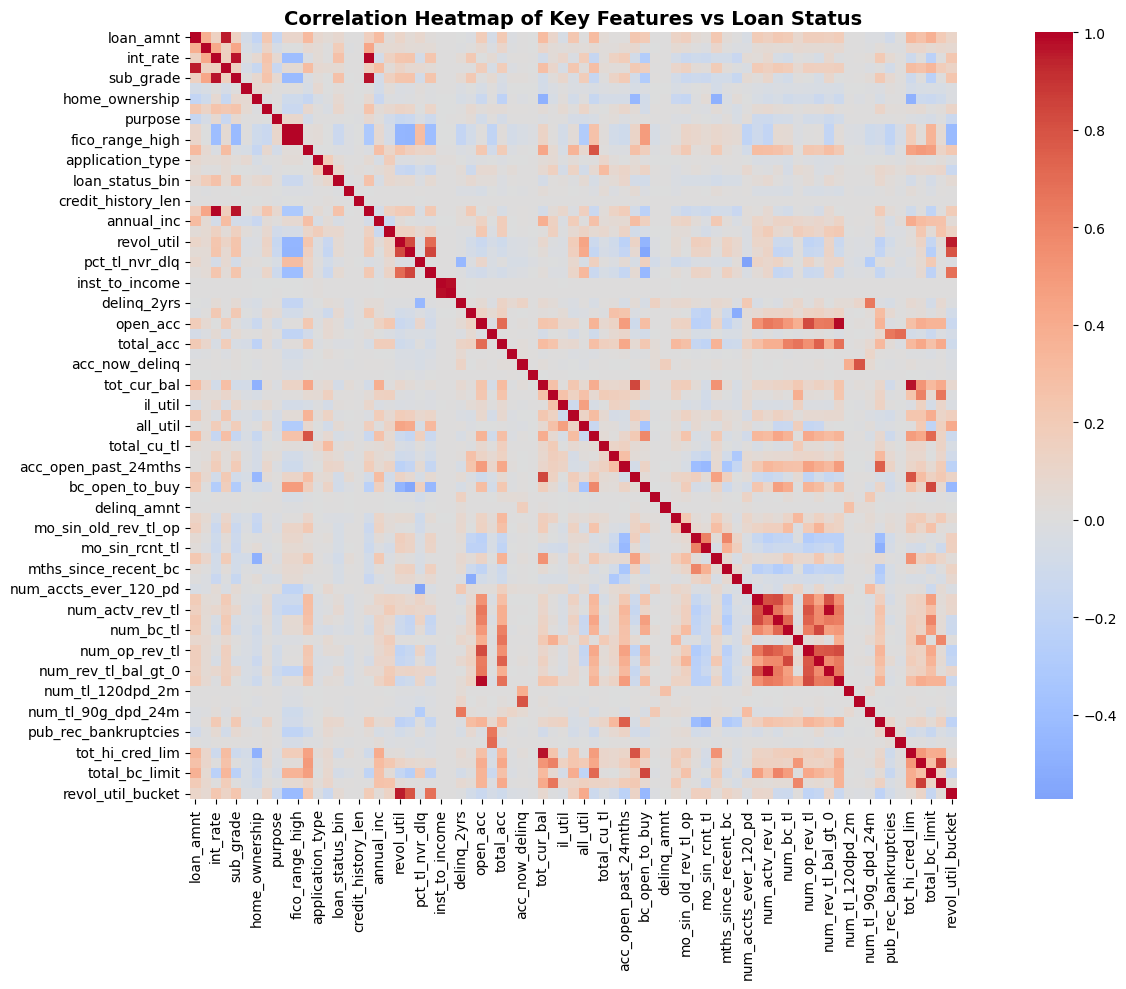


Top correlations with loan_status_bin:
 loan_status_bin    1.000000
sub_grade          0.268313
int_rate           0.263577
fico_x_int         0.259346
term               0.181923
                     ...   
avg_cur_bal       -0.073677
bc_open_to_buy    -0.075252
mort_acc          -0.076964
fico_range_high   -0.129186
fico_range_low    -0.129188
Name: loan_status_bin, Length: 75, dtype: float64


In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,
    fmt=".2f",
    cbar=True,
    square=True
)

plt.title("Correlation Heatmap of Key Features vs Loan Status", fontsize=14, weight="bold")
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

# Print top correlations with target
loan_corr = corr["loan_status_bin"].sort_values(ascending=False)
print("\nTop correlations with loan_status_bin:\n", loan_corr)


In [ ]:
for feature, corr in loan_corr.items():
    print(feature,"\t", corr)

loan_status_bin 	 1.0
sub_grade 	 0.2683125480700767
int_rate 	 0.2635774751035045
fico_x_int 	 0.2593459838792037
term 	 0.18192265924048995
acc_open_past_24mths 	 0.09912493898150142
Year 	 0.08942995138890435
verification_status 	 0.08680954381388445
dti 	 0.08488015204383878
num_tl_op_past_12m 	 0.08366218033263831
loan_amnt 	 0.07290781137529603
home_ownership 	 0.07110001151894643
num_actv_rev_tl 	 0.06876807590191099
num_rev_tl_bal_gt_0 	 0.0669614847362883
inq_last_6mths 	 0.061627702951257385
percent_bc_gt_75 	 0.059612106994501715
installment 	 0.05787349758648041
bc_util 	 0.05739784216188126
revol_util 	 0.054049060346675254
all_util 	 0.051310513782623864
revol_util_bucket 	 0.051273917934136555
inq_last_12m 	 0.046338186004419385
num_actv_bc_tl 	 0.04214420974797906
application_type 	 0.03622797477403573
num_op_rev_tl 	 0.032632787164706654
emp_length 	 0.029397850256931184
open_acc 	 0.026775528149485257
pub_rec 	 0.026087780408160247
pub_rec_bankruptcies 	 0.02570873522

In [ ]:
years = sorted(df_final["Year"].unique().tolist())
print("Years present:", years)

Years present: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [ ]:
if len(years) >= 3:
    m_train, m_val, m_test, train_years, val_years, test_years = chronological_masks_from_years(df_final["Year"], years)
    print(f"Split by years -> Train: {train_years} | Val: {val_years} | Test: {test_years}")
else:
    m_train, m_val, m_test, q1, q2 = chronological_masks_from_quantiles(df_final["Year"])
    print(f"Split by quantiles (fallback) -> Train ≤ {q1}, Val ≤ {q2} (after train), Test > {q2}")


Split by years -> Train: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016] | Val: [2017] | Test: [2018]


In [ ]:
def summarize(mask, name):
    n = mask.sum()
    bad_rate = df_final.loc[mask, "loan_status_bin"].mean() if n > 0 else np.nan
    print(f"{name:<6} -> n={n:,} | default_rate={bad_rate:.3f}")

In [ ]:
summarize(m_train, "Train")
summarize(m_val,   "Val")
summarize(m_test,  "Test")

Train  -> n=1,129,956 | default_rate=0.202
Val    -> n=178,817 | default_rate=0.272
Test   -> n=65,142 | default_rate=0.272


In [ ]:
train_idx = m_train
valid_idx = m_val
test_idx  = m_test

In [ ]:
y_col = "loan_status_bin"
X_def = df_final.drop(["loan_status_bin"],axis=1)
X_cols = X_def.columns
X_train, y_train = df_final.loc[train_idx, X_cols], df_final.loc[train_idx, y_col]
X_valid, y_valid = df_final.loc[valid_idx, X_cols], df_final.loc[valid_idx, y_col]
X_test,  y_test  = df_final.loc[test_idx,  X_cols], df_final.loc[test_idx,  y_col]

In [ ]:
print("Shapes ->",
      "Train:", X_train.shape,
      "| Val:", X_valid.shape,
      "| Test:", X_test.shape)

Shapes -> Train: (1129956, 74) | Val: (178817, 74) | Test: (65142, 74)


In [ ]:
y_train.value_counts()

loan_status_bin
0    901143
1    228813
Name: count, dtype: int64

In [ ]:
def missing_report(X, name):
    miss = X.isna().mean().sort_values(ascending=False)
    print(f"\nTop missingness in {name} (first 15):")
    print((miss.head(15)*100).round(1).astype(str) + "%")

In [ ]:
missing_report(X_train, "Train")
missing_report(X_valid, "Val")
missing_report(X_test, "Test")


Top missingness in Train (first 15):
loan_amnt              0.0%
term                   0.0%
int_rate               0.0%
installment            0.0%
sub_grade              0.0%
emp_length             0.0%
home_ownership         0.0%
verification_status    0.0%
purpose                0.0%
fico_range_low         0.0%
fico_range_high        0.0%
revol_bal              0.0%
application_type       0.0%
Year                   0.0%
region                 0.0%
dtype: object

Top missingness in Val (first 15):
loan_amnt              0.0%
term                   0.0%
int_rate               0.0%
installment            0.0%
sub_grade              0.0%
emp_length             0.0%
home_ownership         0.0%
verification_status    0.0%
purpose                0.0%
fico_range_low         0.0%
fico_range_high        0.0%
revol_bal              0.0%
application_type       0.0%
Year                   0.0%
region                 0.0%
dtype: object

Top missingness in Test (first 15):
loan_amnt            

In [ ]:
over = RandomOverSampler(sampling_strategy=1.0, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)

X_train_over,  y_train_over  = over.fit_resample(X_train,  y_train)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)


print("\nOriginal:")
print(y_train.value_counts().rename({0:"Good",1:"Bad"}))
print("\nAfter OVER-sampling:")
print(y_train_over.value_counts().rename({0:"Good",1:"Bad"}))
print("\nAfter UNDER-sampling:")
print(y_train_under.value_counts().rename({0:"Good",1:"Bad"}))


Original:
loan_status_bin
Good    901143
Bad     228813
Name: count, dtype: int64

After OVER-sampling:
loan_status_bin
Good    901143
Bad     901143
Name: count, dtype: int64

After UNDER-sampling:
loan_status_bin
Good    326875
Bad     228813
Name: count, dtype: int64


In [ ]:
def save_model(model,filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [ ]:
lr_raw = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=500,n_jobs=4))
])

lr_class_weighted = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty='l2', C=1.0, solver='saga',class_weight='balanced', max_iter=500,n_jobs=4))
])

lr_over = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("oversample", RandomOverSampler(sampling_strategy=1.0, random_state=42)),
    ("clf", LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=500,n_jobs=4))
])

lr_under = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("undersample", RandomUnderSampler(sampling_strategy=0.67, random_state=42)),
    ("clf", LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=500,n_jobs=4))
])

In [ ]:
lr_raw.fit(X_train, y_train)
save_model(lr_raw,filename='models/lr_raw.pkl')

/home/odeodhar/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
lr_class_weighted.fit(X_train, y_train)
save_model(lr_class_weighted,filename='models/lr_class_weighted.pkl')

/home/odeodhar/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
lr_over.fit(X_train, y_train)
save_model(lr_over,filename='models/lr_over.pkl')

/home/odeodhar/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
lr_under.fit(X_train, y_train)
save_model(lr_under,filename='models/lr_under.pkl')

/home/odeodhar/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
dt_raw = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", DecisionTreeClassifier(max_depth=6, min_samples_leaf=20))
])

dt_weighted = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", DecisionTreeClassifier(max_depth=6, min_samples_leaf=20, class_weight='balanced'))
])

dt_over = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("oversample", RandomOverSampler(sampling_strategy=1.0, random_state=42)),
    ("clf", DecisionTreeClassifier(max_depth=6, min_samples_leaf=20))
])

dt_under = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("undersample", RandomUnderSampler(sampling_strategy=0.7, random_state=42)),
    ("clf", DecisionTreeClassifier(max_depth=6, min_samples_leaf=20))
])

In [ ]:
dt_raw.fit(X_train, y_train)
save_model(dt_raw,filename='models/dt_raw.pkl')

In [ ]:
dt_weighted.fit(X_train, y_train)
save_model(dt_weighted,filename='models/dt_class_weighted.pkl')

In [ ]:
dt_over.fit(X_train, y_train)
save_model(dt_over,filename='models/dt_over.pkl')

In [ ]:
dt_under.fit(X_train, y_train)
save_model(dt_under,filename='models/dt_under.pkl')

In [ ]:
rf_raw = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=5,
                                          random_state=42, n_jobs=-1))
])

rf_weighted = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=5, class_weight='balanced_subsample',
                                          random_state=42, n_jobs=-1))
])

rf_over = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("oversample", RandomOverSampler(sampling_strategy=1.0, random_state=42)),
    ("clf", RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=5,
                                          random_state=42, n_jobs=-1))
])

rf_under = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("undersample", RandomUnderSampler(sampling_strategy=0.7, random_state=42)),
    ("clf", RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=5,
                                          random_state=42, n_jobs=-1))
])

In [ ]:
rf_raw.fit(X_train, y_train)
save_model(rf_raw,filename='models/rf_raw.pkl')

In [ ]:
rf_weighted.fit(X_train, y_train)
save_model(rf_weighted,filename='models/rf_class_weighted.pkl')

In [ ]:
rf_over.fit(X_train, y_train)
save_model(rf_over,filename='models/rf_over.pkl')

In [ ]:
rf_under.fit(X_train, y_train)
save_model(rf_under,filename='models/rf_under.pkl')

In [ ]:
xgb_raw = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, use_label_encoder=False, eval_metric='auc', n_jobs=-1))
])

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb_weighted = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, use_label_encoder=False, eval_metric='auc', n_jobs=-1, sample_weight=sample_weights))
])

xgb_over = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("oversample", RandomOverSampler(sampling_strategy=1.0, random_state=42)),
    ("clf", XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, use_label_encoder=False, eval_metric='auc', n_jobs=-1))
])

xgb_under = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("undersample", RandomUnderSampler(sampling_strategy=0.7, random_state=42)),
    ("clf", XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, use_label_encoder=False, eval_metric='auc', n_jobs=-1))
])

In [ ]:
xgb_raw.fit(X_train, y_train)
save_model(xgb_raw,filename='models/xgb_raw.pkl')

/home/odeodhar/.local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:45:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
xgb_weighted.fit(X_train, y_train)
save_model(xgb_weighted,filename='models/xgb_class_weighted.pkl')

/home/odeodhar/.local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:45:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "sample_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
xgb_over.fit(X_train, y_train)
save_model(xgb_over,filename='models/xgb_over.pkl')

/home/odeodhar/.local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:45:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
xgb_under.fit(X_train, y_train)
save_model(xgb_under,filename='models/xgb_under.pkl')

/home/odeodhar/.local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:46:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
lgb_raw = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.05,
                                  random_state=42, n_jobs=-1, verbose=-1))
])

lgb_weighted = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.05, class_weight='balanced',
                                  random_state=42, n_jobs=-1, verbose=-1))
])

lgb_over = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("oversample", RandomOverSampler(sampling_strategy=1.0, random_state=42)),
    ("clf", LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.05,
                                  random_state=42, n_jobs=-1, verbose=-1))
])

lgb_under = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("undersample", RandomUnderSampler(sampling_strategy=0.7, random_state=42)),
    ("clf", LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.05,
                                  random_state=42, n_jobs=-1, verbose=-1))
])

In [ ]:
lgb_raw.fit(X_train, y_train)
save_model(lgb_raw,filename='models/lgb_raw.pkl')

In [ ]:
lgb_weighted.fit(X_train, y_train)
save_model(lgb_weighted,filename='models/lgb_class_weighted.pkl')

In [ ]:
lgb_over.fit(X_train, y_train)
save_model(lgb_over,filename='models/lgb_over.pkl')

In [ ]:
lgb_under.fit(X_train, y_train)
save_model(lgb_under,filename='models/lgb_under.pkl')

In [ ]:
sgd_raw = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", SGDClassifier(loss="log_loss", penalty="l2", max_iter=1500))
])

sgd_weighted = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", SGDClassifier(loss="log_loss", penalty="l2", class_weight = 'balanced', max_iter=1500))
])

sgd_over = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("oversample", RandomOverSampler(sampling_strategy=1.0, random_state=42)),
    ("clf", SGDClassifier(loss="log_loss", penalty="l2", max_iter=1500))
])

sgd_under = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("undersample", RandomUnderSampler(sampling_strategy=0.7, random_state=42)),
    ("clf", SGDClassifier(loss="log_loss", penalty="l2", max_iter=1500))
])

In [ ]:
sgd_raw.fit(X_train, y_train)
save_model(sgd_raw,filename='models/sgd_raw.pkl')

In [ ]:
sgd_weighted.fit(X_train, y_train)
save_model(sgd_weighted,filename='models/sgd_class_weighted.pkl')

In [ ]:
sgd_over.fit(X_train, y_train)
save_model(sgd_over,filename='models/sgd_over.pkl')

In [ ]:
sgd_under.fit(X_train, y_train)
save_model(sgd_under,filename='models/sgd_under.pkl')

In [ ]:
nb_raw = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", BernoulliNB())
])

nb_weighted = SkPipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", BernoulliNB())
])

nb_over = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("oversample", RandomOverSampler(sampling_strategy=1.0, random_state=42)),
    ("clf", BernoulliNB())
])

nb_under = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("undersample", RandomUnderSampler(sampling_strategy=0.7, random_state=42)),
    ("clf", BernoulliNB())
])

In [ ]:
nb_raw.fit(X_train, y_train)
save_model(nb_raw,filename='models/nb_raw.pkl')

In [ ]:
nb_over.fit(X_train, y_train)
save_model(nb_over,filename='models/nb_over.pkl')

In [ ]:
nb_under.fit(X_train, y_train)
save_model(nb_under,filename='models/nb_under.pkl')

### Model Evaluation

In [ ]:
# Load models
def load_model(filename):
    with open(filename, "rb") as f:
        model = pickle.load(f)
    return model

In [ ]:
def eval_score(model):
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_valid, y_valid)
    test_score = model.score(X_test, y_test)
    return train_score, val_score, test_score

In [ ]:
def get_preds(model):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_valid)
    y_pred_test = model.predict(X_test)

    y_proba_train = model.predict_proba(X_train)[:,1]
    y_proba_val = model.predict_proba(X_valid)[:,1]
    y_proba_test = model.predict_proba(X_test)[:,1]

    return y_pred_train, y_pred_val, y_pred_test, y_proba_train, y_proba_val, y_proba_test

def get_scores(y_true, y_pred, y_proba):
    auroc = roc_auc_score(y_true, y_proba)
    prauc = average_precision_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return auroc, prauc, f1, precision, recall

# def get_eval_scores(model):

#     train_auroc, train_prauc, train_f1, train_precision, train_recall = get_scores(y_train, y_pred_train, y_proba_train)
#     test_auroc, test_prauc, test_f1, test_precision, test_recall = get_scores(y_test, y_pred_test, y_proba_test)
#     val_auroc, val_prauc, val_f1, val_precision, val_recall = get_scores(y_valid, y_pred_val, y_proba_val)

#     return train_auroc, train_prauc, train_f1, train_precision, train_recall, val_auroc, val_prauc, val_f1, val_precision, val_recall, test_auroc, test_prauc, test_f1, test_precision, test_recall


In [ ]:
# Logistic Regression

lr_raw = load_model('models/lr_raw.pkl')
lr_class_weighted = load_model('models/lr_class_weighted.pkl')
lr_over = load_model('models/lr_over.pkl')
lr_under = load_model('models/lr_under.pkl')

In [ ]:
lr_raw_acc_train, lr_raw_acc_val, lr_raw_acc_test = eval_score(lr_raw)
lr_cw_acc_train, lr_cw_acc_val, lr_cw_acc_test = eval_score(lr_class_weighted)
lr_over_acc_train, lr_over_acc_val, lr_over_acc_test = eval_score(lr_over)
lr_under_acc_train, lr_under_acc_val, lr_under_acc_test = eval_score(lr_under)

In [ ]:
y_pred_train_lr_raw, y_pred_val_lr_raw, y_pred_test_lr_raw, y_proba_train_lr_raw, y_proba_val_lr_raw, y_proba_test_lr_raw = get_preds(lr_raw)
y_pred_train_lr_cw, y_pred_val_lr_cw, y_pred_test_lr_cw, y_proba_train_lr_cw, y_proba_val_lr_cw, y_proba_test_lr_cw = get_preds(lr_class_weighted)
y_pred_train_lr_over, y_pred_val_lr_over, y_pred_test_lr_over, y_proba_train_lr_over, y_proba_val_lr_over, y_proba_test_lr_over = get_preds(lr_over)
y_pred_train_lr_under, y_pred_val_lr_under, y_pred_test_lr_under, y_proba_train_lr_under, y_proba_val_lr_under, y_proba_test_lr_under = get_preds(lr_under)

In [ ]:
# lr_raw
lr_raw_auroc_train, lr_raw_prauc_train, lr_raw_f1_train, lr_raw_precision_train, lr_raw_recall_train = get_scores(y_train, y_pred_train_lr_raw, y_proba_train_lr_raw)
lr_raw_auroc_val, lr_raw_prauc_val, lr_raw_f1_val, lr_raw_precision_val, lr_raw_recall_val = get_scores(y_valid, y_pred_val_lr_raw, y_proba_val_lr_raw)
lr_raw_auroc_test, lr_raw_prauc_test, lr_raw_f1_test, lr_raw_precision_test, lr_raw_recall_test = get_scores(y_test, y_pred_test_lr_raw, y_proba_test_lr_raw)
# lr_class_weighted
lr_cw_auroc_train, lr_cw_prauc_train, lr_cw_f1_train, lr_cw_precision_train, lr_cw_recall_train = get_scores(y_train, y_pred_train_lr_cw, y_proba_train_lr_cw)
lr_cw_auroc_val, lr_cw_prauc_val, lr_cw_f1_val, lr_cw_precision_val, lr_cw_recall_val = get_scores(y_valid, y_pred_val_lr_cw, y_proba_val_lr_cw)
lr_cw_auroc_test, lr_cw_prauc_test, lr_cw_f1_test, lr_cw_precision_test, lr_cw_recall_test = get_scores(y_test, y_pred_test_lr_cw, y_proba_test_lr_cw)
# lr_over
lr_over_auroc_train, lr_over_prauc_train, lr_over_f1_train, lr_over_precision_train, lr_over_recall_train = get_scores(y_train, y_pred_train_lr_over, y_proba_train_lr_over)
lr_over_auroc_val, lr_over_prauc_val, lr_over_f1_val, lr_over_precision_val, lr_over_recall_val = get_scores(y_valid, y_pred_val_lr_over, y_proba_val_lr_over)
lr_over_auroc_test, lr_over_prauc_test, lr_over_f1_test, lr_over_precision_test, lr_over_recall_test = get_scores(y_test, y_pred_test_lr_over, y_proba_test_lr_over)
# lr_under
lr_under_auroc_train, lr_under_prauc_train, lr_under_f1_train, lr_under_precision_train, lr_under_recall_train = get_scores(y_train, y_pred_train_lr_under, y_proba_train_lr_under)
lr_under_auroc_val, lr_under_prauc_val, lr_under_f1_val, lr_under_precision_val, lr_under_recall_val = get_scores(y_valid, y_pred_val_lr_under, y_proba_val_lr_under)
lr_under_auroc_test, lr_under_prauc_test, lr_under_f1_test, lr_under_precision_test, lr_under_recall_test = get_scores(y_test, y_pred_test_lr_under, y_proba_test_lr_under)

In [ ]:
# Decision Tree

dt_raw = load_model('models/dt_raw.pkl')
dt_class_weighted = load_model('models/dt_class_weighted.pkl')
dt_over = load_model('models/dt_over.pkl')
dt_under = load_model('models/dt_under.pkl')

In [ ]:
dt_raw_acc_train, dt_raw_acc_val, dt_raw_acc_test = eval_score(dt_raw)
dt_cw_acc_train, dt_cw_acc_val, dt_cw_acc_test = eval_score(dt_class_weighted)
dt_over_acc_train, dt_over_acc_val, dt_over_acc_test = eval_score(dt_over)
dt_under_acc_train, dt_under_acc_val, dt_under_acc_test = eval_score(dt_under)

In [ ]:
y_pred_train_dt_raw, y_pred_val_dt_raw, y_pred_test_dt_raw, y_proba_train_dt_raw, y_proba_val_dt_raw, y_proba_test_dt_raw = get_preds(dt_raw)
y_pred_train_dt_cw, y_pred_val_dt_cw, y_pred_test_dt_cw, y_proba_train_dt_cw, y_proba_val_dt_cw, y_proba_test_dt_cw = get_preds(dt_class_weighted)
y_pred_train_dt_over, y_pred_val_dt_over, y_pred_test_dt_over, y_proba_train_dt_over, y_proba_val_dt_over, y_proba_test_dt_over = get_preds(dt_over)
y_pred_train_dt_under, y_pred_val_dt_under, y_pred_test_dt_under, y_proba_train_dt_under, y_proba_val_dt_under, y_proba_test_dt_under = get_preds(dt_under)

In [ ]:
# dt_raw
dt_raw_auroc_train, dt_raw_prauc_train, dt_raw_f1_train, dt_raw_precision_train, dt_raw_recall_train = get_scores(y_train, y_pred_train_dt_raw, y_proba_train_dt_raw)
dt_raw_auroc_val, dt_raw_prauc_val, dt_raw_f1_val, dt_raw_precision_val, dt_raw_recall_val = get_scores(y_valid, y_pred_val_dt_raw, y_proba_val_dt_raw)
dt_raw_auroc_test, dt_raw_prauc_test, dt_raw_f1_test, dt_raw_precision_test, dt_raw_recall_test = get_scores(y_test, y_pred_test_dt_raw, y_proba_test_dt_raw)
# dt_class_weighted
dt_cw_auroc_train, dt_cw_prauc_train, dt_cw_f1_train, dt_cw_precision_train, dt_cw_recall_train = get_scores(y_train, y_pred_train_dt_cw, y_proba_train_dt_cw)
dt_cw_auroc_val, dt_cw_prauc_val, dt_cw_f1_val, dt_cw_precision_val, dt_cw_recall_val = get_scores(y_valid, y_pred_val_dt_cw, y_proba_val_dt_cw)
dt_cw_auroc_test, dt_cw_prauc_test, dt_cw_f1_test, dt_cw_precision_test, dt_cw_recall_test = get_scores(y_test, y_pred_test_dt_cw, y_proba_test_dt_cw)
# dt_over
dt_over_auroc_train, dt_over_prauc_train, dt_over_f1_train, dt_over_precision_train, dt_over_recall_train = get_scores(y_train, y_pred_train_dt_over, y_proba_train_dt_over)
dt_over_auroc_val, dt_over_prauc_val, dt_over_f1_val, dt_over_precision_val, dt_over_recall_val = get_scores(y_valid, y_pred_val_dt_over, y_proba_val_dt_over)
dt_over_auroc_test, dt_over_prauc_test, dt_over_f1_test, dt_over_precision_test, dt_over_recall_test = get_scores(y_test, y_pred_test_dt_over, y_proba_test_dt_over)
# dt_under
dt_under_auroc_train, dt_under_prauc_train, dt_under_f1_train, dt_under_precision_train, dt_under_recall_train = get_scores(y_train, y_pred_train_dt_under, y_proba_train_dt_under)
dt_under_auroc_val, dt_under_prauc_val, dt_under_f1_val, dt_under_precision_val, dt_under_recall_val = get_scores(y_valid, y_pred_val_dt_under, y_proba_val_dt_under)
dt_under_auroc_test, dt_under_prauc_test, dt_under_f1_test, dt_under_precision_test, dt_under_recall_test = get_scores(y_test, y_pred_test_dt_under, y_proba_test_dt_under)

In [ ]:
# Random Forest

rf_raw = load_model('models/rf_raw.pkl')
rf_class_weighted = load_model('models/rf_class_weighted.pkl')
rf_over = load_model('models/rf_over.pkl')
rf_under = load_model('models/rf_under.pkl')

In [ ]:
rf_raw_acc_train, rf_raw_acc_val, rf_raw_acc_test = eval_score(rf_raw)
rf_cw_acc_train, rf_cw_acc_val, rf_cw_acc_test = eval_score(rf_class_weighted)
rf_over_acc_train, rf_over_acc_val, rf_over_acc_test = eval_score(rf_over)
rf_under_acc_train, rf_under_acc_val, rf_under_acc_test = eval_score(rf_under)

In [ ]:
y_pred_train_rf_raw, y_pred_val_rf_raw, y_pred_test_rf_raw, y_proba_train_rf_raw, y_proba_val_rf_raw, y_proba_test_rf_raw = get_preds(rf_raw)
y_pred_train_rf_cw, y_pred_val_rf_cw, y_pred_test_rf_cw, y_proba_train_rf_cw, y_proba_val_rf_cw, y_proba_test_rf_cw = get_preds(rf_class_weighted)
y_pred_train_rf_over, y_pred_val_rf_over, y_pred_test_rf_over, y_proba_train_rf_over, y_proba_val_rf_over, y_proba_test_rf_over = get_preds(rf_over)
y_pred_train_rf_under, y_pred_val_rf_under, y_pred_test_rf_under, y_proba_train_rf_under, y_proba_val_rf_under, y_proba_test_rf_under = get_preds(rf_under)

In [ ]:
# rf_raw
rf_raw_auroc_train, rf_raw_prauc_train, rf_raw_f1_train, rf_raw_precision_train, rf_raw_recall_train = get_scores(y_train, y_pred_train_rf_raw, y_proba_train_rf_raw)
rf_raw_auroc_val, rf_raw_prauc_val, rf_raw_f1_val, rf_raw_precision_val, rf_raw_recall_val = get_scores(y_valid, y_pred_val_rf_raw, y_proba_val_rf_raw)
rf_raw_auroc_test, rf_raw_prauc_test, rf_raw_f1_test, rf_raw_precision_test, rf_raw_recall_test = get_scores(y_test, y_pred_test_rf_raw, y_proba_test_rf_raw)
# rf_class_weighted
rf_cw_auroc_train, rf_cw_prauc_train, rf_cw_f1_train, rf_cw_precision_train, rf_cw_recall_train = get_scores(y_train, y_pred_train_rf_cw, y_proba_train_rf_cw)
rf_cw_auroc_val, rf_cw_prauc_val, rf_cw_f1_val, rf_cw_precision_val, rf_cw_recall_val = get_scores(y_valid, y_pred_val_rf_cw, y_proba_val_rf_cw)
rf_cw_auroc_test, rf_cw_prauc_test, rf_cw_f1_test, rf_cw_precision_test, rf_cw_recall_test = get_scores(y_test, y_pred_test_rf_cw, y_proba_test_rf_cw)
# rf_over
rf_over_auroc_train, rf_over_prauc_train, rf_over_f1_train, rf_over_precision_train, rf_over_recall_train = get_scores(y_train, y_pred_train_rf_over, y_proba_train_rf_over)
rf_over_auroc_val, rf_over_prauc_val, rf_over_f1_val, rf_over_precision_val, rf_over_recall_val = get_scores(y_valid, y_pred_val_rf_over, y_proba_val_rf_over)
rf_over_auroc_test, rf_over_prauc_test, rf_over_f1_test, rf_over_precision_test, rf_over_recall_test = get_scores(y_test, y_pred_test_rf_over, y_proba_test_rf_over)
# rf_under
rf_under_auroc_train, rf_under_prauc_train, rf_under_f1_train, rf_under_precision_train, rf_under_recall_train = get_scores(y_train, y_pred_train_rf_under, y_proba_train_rf_under)
rf_under_auroc_val, rf_under_prauc_val, rf_under_f1_val, rf_under_precision_val, rf_under_recall_val = get_scores(y_valid, y_pred_val_rf_under, y_proba_val_rf_under)
rf_under_auroc_test, rf_under_prauc_test, rf_under_f1_test, rf_under_precision_test, rf_under_recall_test = get_scores(y_test, y_pred_test_rf_under, y_proba_test_rf_under)

In [ ]:
# XGBoost

xgb_raw = load_model('models/xgb_raw.pkl')
xgb_class_weighted = load_model('models/xgb_class_weighted.pkl')
xgb_over = load_model('models/xgb_over.pkl')
xgb_under = load_model('models/xgb_under.pkl')

C:\Users\Admin\AppData\Local\Temp\ipykernel_22588\2599786368.py:4: UserWarning: [10:58:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  model = pickle.load(f)


In [ ]:
xgb_raw_acc_train, xgb_raw_acc_val, xgb_raw_acc_test = eval_score(xgb_raw)
xgb_cw_acc_train, xgb_cw_acc_val, xgb_cw_acc_test = eval_score(xgb_class_weighted)
xgb_over_acc_train, xgb_over_acc_val, xgb_over_acc_test = eval_score(xgb_over)
xgb_under_acc_train, xgb_under_acc_val, xgb_under_acc_test = eval_score(xgb_under)

In [ ]:
y_pred_train_xgb_raw, y_pred_val_xgb_raw, y_pred_test_xgb_raw, y_proba_train_xgb_raw, y_proba_val_xgb_raw, y_proba_test_xgb_raw = get_preds(xgb_raw)
y_pred_train_xgb_cw, y_pred_val_xgb_cw, y_pred_test_xgb_cw, y_proba_train_xgb_cw, y_proba_val_xgb_cw, y_proba_test_xgb_cw = get_preds(xgb_class_weighted)
y_pred_train_xgb_over, y_pred_val_xgb_over, y_pred_test_xgb_over, y_proba_train_xgb_over, y_proba_val_xgb_over, y_proba_test_xgb_over = get_preds(xgb_over)
y_pred_train_xgb_under, y_pred_val_xgb_under, y_pred_test_xgb_under, y_proba_train_xgb_under, y_proba_val_xgb_under, y_proba_test_xgb_under = get_preds(xgb_under)

In [ ]:
# xgb_raw
xgb_raw_auroc_train, xgb_raw_prauc_train, xgb_raw_f1_train, xgb_raw_precision_train, xgb_raw_recall_train = get_scores(y_train, y_pred_train_xgb_raw, y_proba_train_xgb_raw)
xgb_raw_auroc_val, xgb_raw_prauc_val, xgb_raw_f1_val, xgb_raw_precision_val, xgb_raw_recall_val = get_scores(y_valid, y_pred_val_xgb_raw, y_proba_val_xgb_raw)
xgb_raw_auroc_test, xgb_raw_prauc_test, xgb_raw_f1_test, xgb_raw_precision_test, xgb_raw_recall_test = get_scores(y_test, y_pred_test_xgb_raw, y_proba_test_xgb_raw)
# xgb_class_weighted
xgb_cw_auroc_train, xgb_cw_prauc_train, xgb_cw_f1_train, xgb_cw_precision_train, xgb_cw_recall_train = get_scores(y_train, y_pred_train_xgb_cw, y_proba_train_xgb_cw)
xgb_cw_auroc_val, xgb_cw_prauc_val, xgb_cw_f1_val, xgb_cw_precision_val, xgb_cw_recall_val = get_scores(y_valid, y_pred_val_xgb_cw, y_proba_val_xgb_cw)
xgb_cw_auroc_test, xgb_cw_prauc_test, xgb_cw_f1_test, xgb_cw_precision_test, xgb_cw_recall_test = get_scores(y_test, y_pred_test_xgb_cw, y_proba_test_xgb_cw)
# xgb_over
xgb_over_auroc_train, xgb_over_prauc_train, xgb_over_f1_train, xgb_over_precision_train, xgb_over_recall_train = get_scores(y_train, y_pred_train_xgb_over, y_proba_train_xgb_over)
xgb_over_auroc_val, xgb_over_prauc_val, xgb_over_f1_val, xgb_over_precision_val, xgb_over_recall_val = get_scores(y_valid, y_pred_val_xgb_over, y_proba_val_xgb_over)
xgb_over_auroc_test, xgb_over_prauc_test, xgb_over_f1_test, xgb_over_precision_test, xgb_over_recall_test = get_scores(y_test, y_pred_test_xgb_over, y_proba_test_xgb_over)
# xgb_under
xgb_under_auroc_train, xgb_under_prauc_train, xgb_under_f1_train, xgb_under_precision_train, xgb_under_recall_train = get_scores(y_train, y_pred_train_xgb_under, y_proba_train_xgb_under)
xgb_under_auroc_val, xgb_under_prauc_val, xgb_under_f1_val, xgb_under_precision_val, xgb_under_recall_val = get_scores(y_valid, y_pred_val_xgb_under, y_proba_val_xgb_under)
xgb_under_auroc_test, xgb_under_prauc_test, xgb_under_f1_test, xgb_under_precision_test, xgb_under_recall_test = get_scores(y_test, y_pred_test_xgb_under, y_proba_test_xgb_under)

In [ ]:
# Light GBM

lgb_raw = load_model('models/lgb_raw.pkl')
lgb_class_weighted = load_model('models/lgb_class_weighted.pkl')
lgb_over = load_model('models/lgb_over.pkl')
lgb_under = load_model('models/lgb_under.pkl')

In [ ]:
lgb_raw_acc_train, lgb_raw_acc_val, lgb_raw_acc_test = eval_score(lgb_raw)
lgb_cw_acc_train, lgb_cw_acc_val, lgb_cw_acc_test = eval_score(lgb_class_weighted)
lgb_over_acc_train, lgb_over_acc_val, lgb_over_acc_test = eval_score(lgb_over)
lgb_under_acc_train, lgb_under_acc_val, lgb_under_acc_test = eval_score(lgb_under)

C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifi

In [ ]:
y_pred_train_lgb_raw, y_pred_val_lgb_raw, y_pred_test_lgb_raw, y_proba_train_lgb_raw, y_proba_val_lgb_raw, y_proba_test_lgb_raw = get_preds(lgb_raw)
y_pred_train_lgb_cw, y_pred_val_lgb_cw, y_pred_test_lgb_cw, y_proba_train_lgb_cw, y_proba_val_lgb_cw, y_proba_test_lgb_cw = get_preds(lgb_class_weighted)
y_pred_train_lgb_over, y_pred_val_lgb_over, y_pred_test_lgb_over, y_proba_train_lgb_over, y_proba_val_lgb_over, y_proba_test_lgb_over = get_preds(lgb_over)
y_pred_train_lgb_under, y_pred_val_lgb_under, y_pred_test_lgb_under, y_proba_train_lgb_under, y_proba_val_lgb_under, y_proba_test_lgb_under = get_preds(lgb_under)

C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\envs\data_mining\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifi

In [ ]:
# lgb_raw
lgb_raw_auroc_train, lgb_raw_prauc_train, lgb_raw_f1_train, lgb_raw_precision_train, lgb_raw_recall_train = get_scores(y_train, y_pred_train_lgb_raw, y_proba_train_lgb_raw)
lgb_raw_auroc_val, lgb_raw_prauc_val, lgb_raw_f1_val, lgb_raw_precision_val, lgb_raw_recall_val = get_scores(y_valid, y_pred_val_lgb_raw, y_proba_val_lgb_raw)
lgb_raw_auroc_test, lgb_raw_prauc_test, lgb_raw_f1_test, lgb_raw_precision_test, lgb_raw_recall_test = get_scores(y_test, y_pred_test_lgb_raw, y_proba_test_lgb_raw)
# lgb_class_weighted
lgb_cw_auroc_train, lgb_cw_prauc_train, lgb_cw_f1_train, lgb_cw_precision_train, lgb_cw_recall_train = get_scores(y_train, y_pred_train_lgb_cw, y_proba_train_lgb_cw)
lgb_cw_auroc_val, lgb_cw_prauc_val, lgb_cw_f1_val, lgb_cw_precision_val, lgb_cw_recall_val = get_scores(y_valid, y_pred_val_lgb_cw, y_proba_val_lgb_cw)
lgb_cw_auroc_test, lgb_cw_prauc_test, lgb_cw_f1_test, lgb_cw_precision_test, lgb_cw_recall_test = get_scores(y_test, y_pred_test_lgb_cw, y_proba_test_lgb_cw)
# lgb_over
lgb_over_auroc_train, lgb_over_prauc_train, lgb_over_f1_train, lgb_over_precision_train, lgb_over_recall_train = get_scores(y_train, y_pred_train_lgb_over, y_proba_train_lgb_over)
lgb_over_auroc_val, lgb_over_prauc_val, lgb_over_f1_val, lgb_over_precision_val, lgb_over_recall_val = get_scores(y_valid, y_pred_val_lgb_over, y_proba_val_lgb_over)
lgb_over_auroc_test, lgb_over_prauc_test, lgb_over_f1_test, lgb_over_precision_test, lgb_over_recall_test = get_scores(y_test, y_pred_test_lgb_over, y_proba_test_lgb_over)
# lgb_under
lgb_under_auroc_train, lgb_under_prauc_train, lgb_under_f1_train, lgb_under_precision_train, lgb_under_recall_train = get_scores(y_train, y_pred_train_lgb_under, y_proba_train_lgb_under)
lgb_under_auroc_val, lgb_under_prauc_val, lgb_under_f1_val, lgb_under_precision_val, lgb_under_recall_val = get_scores(y_valid, y_pred_val_lgb_under, y_proba_val_lgb_under)
lgb_under_auroc_test, lgb_under_prauc_test, lgb_under_f1_test, lgb_under_precision_test, lgb_under_recall_test = get_scores(y_test, y_pred_test_lgb_under, y_proba_test_lgb_under)

In [ ]:
# Stochastic Gradient Descent

sgd_raw = load_model('models/sgd_raw.pkl')
sgd_class_weighted = load_model('models/sgd_class_weighted.pkl')
sgd_over = load_model('models/sgd_over.pkl')
sgd_under = load_model('models/sgd_under.pkl')

In [ ]:
sgd_raw_acc_train, sgd_raw_acc_val, sgd_raw_acc_test = eval_score(sgd_raw)
sgd_cw_acc_train, sgd_cw_acc_val, sgd_cw_acc_test = eval_score(sgd_class_weighted)
sgd_over_acc_train, sgd_over_acc_val, sgd_over_acc_test = eval_score(sgd_over)
sgd_under_acc_train, sgd_under_acc_val, sgd_under_acc_test = eval_score(sgd_under)

In [ ]:
y_pred_train_sgd_raw, y_pred_val_sgd_raw, y_pred_test_sgd_raw, y_proba_train_sgd_raw, y_proba_val_sgd_raw, y_proba_test_sgd_raw = get_preds(sgd_raw)
y_pred_train_sgd_cw, y_pred_val_sgd_cw, y_pred_test_sgd_cw, y_proba_train_sgd_cw, y_proba_val_sgd_cw, y_proba_test_sgd_cw = get_preds(sgd_class_weighted)
y_pred_train_sgd_over, y_pred_val_sgd_over, y_pred_test_sgd_over, y_proba_train_sgd_over, y_proba_val_sgd_over, y_proba_test_sgd_over = get_preds(sgd_over)
y_pred_train_sgd_under, y_pred_val_sgd_under, y_pred_test_sgd_under, y_proba_train_sgd_under, y_proba_val_sgd_under, y_proba_test_sgd_under = get_preds(sgd_under)

In [ ]:
# sgd_raw
sgd_raw_auroc_train, sgd_raw_prauc_train, sgd_raw_f1_train, sgd_raw_precision_train, sgd_raw_recall_train = get_scores(y_train, y_pred_train_sgd_raw, y_proba_train_sgd_raw)
sgd_raw_auroc_val, sgd_raw_prauc_val, sgd_raw_f1_val, sgd_raw_precision_val, sgd_raw_recall_val = get_scores(y_valid, y_pred_val_sgd_raw, y_proba_val_sgd_raw)
sgd_raw_auroc_test, sgd_raw_prauc_test, sgd_raw_f1_test, sgd_raw_precision_test, sgd_raw_recall_test = get_scores(y_test, y_pred_test_sgd_raw, y_proba_test_sgd_raw)
# sgd_class_weighted
sgd_cw_auroc_train, sgd_cw_prauc_train, sgd_cw_f1_train, sgd_cw_precision_train, sgd_cw_recall_train = get_scores(y_train, y_pred_train_sgd_cw, y_proba_train_sgd_cw)
sgd_cw_auroc_val, sgd_cw_prauc_val, sgd_cw_f1_val, sgd_cw_precision_val, sgd_cw_recall_val = get_scores(y_valid, y_pred_val_sgd_cw, y_proba_val_sgd_cw)
sgd_cw_auroc_test, sgd_cw_prauc_test, sgd_cw_f1_test, sgd_cw_precision_test, sgd_cw_recall_test = get_scores(y_test, y_pred_test_sgd_cw, y_proba_test_sgd_cw)
# sgd_over
sgd_over_auroc_train, sgd_over_prauc_train, sgd_over_f1_train, sgd_over_precision_train, sgd_over_recall_train = get_scores(y_train, y_pred_train_sgd_over, y_proba_train_sgd_over)
sgd_over_auroc_val, sgd_over_prauc_val, sgd_over_f1_val, sgd_over_precision_val, sgd_over_recall_val = get_scores(y_valid, y_pred_val_sgd_over, y_proba_val_sgd_over)
sgd_over_auroc_test, sgd_over_prauc_test, sgd_over_f1_test, sgd_over_precision_test, sgd_over_recall_test = get_scores(y_test, y_pred_test_sgd_over, y_proba_test_sgd_over)
# sgd_under
sgd_under_auroc_train, sgd_under_prauc_train, sgd_under_f1_train, sgd_under_precision_train, sgd_under_recall_train = get_scores(y_train, y_pred_train_sgd_under, y_proba_train_sgd_under)
sgd_under_auroc_val, sgd_under_prauc_val, sgd_under_f1_val, sgd_under_precision_val, sgd_under_recall_val = get_scores(y_valid, y_pred_val_sgd_under, y_proba_val_sgd_under)
sgd_under_auroc_test, sgd_under_prauc_test, sgd_under_f1_test, sgd_under_precision_test, sgd_under_recall_test = get_scores(y_test, y_pred_test_sgd_under, y_proba_test_sgd_under)

In [ ]:
# Naive Bayes (BernoulliNB)

nb_raw = load_model('models/nb_raw.pkl')
nb_over = load_model('models/nb_over.pkl')
nb_under = load_model('models/nb_under.pkl')

In [ ]:
nb_raw_acc_train, nb_raw_acc_val, nb_raw_acc_test = eval_score(nb_raw)
nb_over_acc_train, nb_over_acc_val, nb_over_acc_test = eval_score(nb_over)
nb_under_acc_train, nb_under_acc_val, nb_under_acc_test = eval_score(nb_under)

In [ ]:
y_pred_train_nb_raw, y_pred_val_nb_raw, y_pred_test_nb_raw, y_proba_train_nb_raw, y_proba_val_nb_raw, y_proba_test_nb_raw = get_preds(nb_raw)
y_pred_train_nb_over, y_pred_val_nb_over, y_pred_test_nb_over, y_proba_train_nb_over, y_proba_val_nb_over, y_proba_test_nb_over = get_preds(nb_over)
y_pred_train_nb_under, y_pred_val_nb_under, y_pred_test_nb_under, y_proba_train_nb_under, y_proba_val_nb_under, y_proba_test_nb_under = get_preds(nb_under)

In [ ]:
# nb_raw
nb_raw_auroc_train, nb_raw_prauc_train, nb_raw_f1_train, nb_raw_precision_train, nb_raw_recall_train = get_scores(y_train, y_pred_train_nb_raw, y_proba_train_nb_raw)
nb_raw_auroc_val, nb_raw_prauc_val, nb_raw_f1_val, nb_raw_precision_val, nb_raw_recall_val = get_scores(y_valid, y_pred_val_nb_raw, y_proba_val_nb_raw)
nb_raw_auroc_test, nb_raw_prauc_test, nb_raw_f1_test, nb_raw_precision_test, nb_raw_recall_test = get_scores(y_test, y_pred_test_nb_raw, y_proba_test_nb_raw)
# nb_over
nb_over_auroc_train, nb_over_prauc_train, nb_over_f1_train, nb_over_precision_train, nb_over_recall_train = get_scores(y_train, y_pred_train_nb_over, y_proba_train_nb_over)
nb_over_auroc_val, nb_over_prauc_val, nb_over_f1_val, nb_over_precision_val, nb_over_recall_val = get_scores(y_valid, y_pred_val_nb_over, y_proba_val_nb_over)
nb_over_auroc_test, nb_over_prauc_test, nb_over_f1_test, nb_over_precision_test, nb_over_recall_test = get_scores(y_test, y_pred_test_nb_over, y_proba_test_nb_over)
# nb_under
nb_under_auroc_train, nb_under_prauc_train, nb_under_f1_train, nb_under_precision_train, nb_under_recall_train = get_scores(y_train, y_pred_train_nb_under, y_proba_train_nb_under)
nb_under_auroc_val, nb_under_prauc_val, nb_under_f1_val, nb_under_precision_val, nb_under_recall_val = get_scores(y_valid, y_pred_val_nb_under, y_proba_val_nb_under)
nb_under_auroc_test, nb_under_prauc_test, nb_under_f1_test, nb_under_precision_test, nb_under_recall_test = get_scores(y_test, y_pred_test_nb_under, y_proba_test_nb_under)

In [ ]:
# Save results in dataframe
def create_detailed_results_dataframe():
    results = []

    # Define all your model variants
    models_variants = [
        # (model_name, variant_name, train_score, val_score, test_score)
        ('Logistic Regression', 'Raw', lr_raw_recall_train, lr_raw_recall_val, lr_raw_recall_test),
        ('Logistic Regression', 'Class Weighted', lr_cw_recall_train, lr_cw_recall_val, lr_cw_recall_test),
        ('Logistic Regression', 'Oversampled', lr_over_recall_train, lr_over_recall_val, lr_over_recall_test),
        ('Logistic Regression', 'Undersampled', lr_under_recall_train, lr_under_recall_val, lr_under_recall_test),

        ('Decision Tree', 'Raw', dt_raw_recall_train, dt_raw_recall_val, dt_raw_recall_test),
        ('Decision Tree', 'Class Weighted', dt_cw_recall_train, dt_cw_recall_val, dt_cw_recall_test),
        ('Decision Tree', 'Oversampled', dt_over_recall_train, dt_over_recall_val, dt_over_recall_test),
        ('Decision Tree', 'Undersampled', dt_under_recall_train, dt_under_recall_val, dt_under_recall_test),

        ('Random Forest', 'Raw', rf_raw_recall_train, rf_raw_recall_val, rf_raw_recall_test),
        ('Random Forest', 'Class Weighted', rf_cw_recall_train, rf_cw_recall_val, rf_cw_recall_test),
        ('Random Forest', 'Oversampled', rf_over_recall_train, rf_over_recall_val, rf_over_recall_test),
        ('Random Forest', 'Undersampled', rf_under_recall_train, rf_under_recall_val, rf_under_recall_test),

        ('XGBoost', 'Raw', xgb_raw_precision_train, xgb_raw_precision_val, xgb_raw_precision_test),
        ('XGBoost', 'Class Weighted', xgb_cw_precision_train, xgb_cw_precision_val, xgb_cw_precision_test),
        ('XGBoost', 'Oversampled', xgb_over_precision_train, xgb_over_precision_val, xgb_over_precision_test),
        ('XGBoost', 'Undersampled', xgb_under_precision_train, xgb_under_precision_val, xgb_under_precision_test),

        ('LGBM', 'Raw', lgb_raw_recall_train, lgb_raw_recall_val, lgb_raw_recall_test),
        ('LGBM', 'Class Weighted', lgb_cw_recall_train, lgb_cw_recall_val, lgb_cw_recall_test),
        ('LGBM', 'Oversampled', lgb_over_recall_train, lgb_over_recall_val, lgb_over_recall_test),
        ('LGBM', 'Undersampled', lgb_under_recall_train, lgb_under_recall_val, lgb_under_recall_test),

        ('SGD', 'Raw', sgd_raw_recall_train, sgd_raw_recall_val, sgd_raw_recall_test),
        ('SGB', 'Class Weighted', sgd_cw_recall_train, sgd_cw_recall_val, sgd_cw_recall_test),
        ('SGD', 'Oversampled', sgd_over_recall_train, sgd_over_recall_val, sgd_over_recall_test),
        ('SGD', 'Undersampled', sgd_under_recall_train, sgd_under_recall_val, sgd_under_recall_test),

        ('Naive Bayes', 'Raw', nb_raw_recall_train, nb_raw_recall_val, nb_raw_recall_test),
        ('Naive Bayes', 'Oversampled', nb_over_recall_train, nb_over_recall_val, nb_over_recall_test),
        ('Naive Bayes', 'Undersampled', nb_under_recall_train, nb_under_recall_val, nb_under_recall_test),
    ]

    for model, variant, train, val, test in models_variants:
        # Calculate overfitting gap (train - validation)
        #overfitting_gap = train - val

        results.append({
            'model': model,
            'variant': variant,
            'train_score': train,
            'val_score': val,
            'test_score': test,
            #'overfitting_gap': overfitting_gap,
            #'val_test_diff': val - test  # Generalization gap
        })

    df = pd.DataFrame(results)

    # Add ranking columns
    #df['test_rank'] = df['test_score'].rank(ascending=False, method='dense')
    #df['val_rank'] = df['val_score'].rank(ascending=False, method='dense')

    return df

# Create detailed DataFrame
detailed_df = create_detailed_results_dataframe()

# Display results
print("Detailed Model Results:")
print("=" * 70)
print(detailed_df.to_string(index=False))

# Save to CSV
detailed_df.to_csv('model_comparison_recall.csv', index=False)
print("\nResults saved to 'model_comparison_recall.csv'")

Detailed Model Results:
              model        variant  train_score  val_score  test_score
Logistic Regression            Raw     0.111261   0.162807    0.183185
Logistic Regression Class Weighted     0.651947   0.764656    0.780992
Logistic Regression    Oversampled     0.652262   0.765889    0.782292
Logistic Regression   Undersampled     0.460979   0.574273    0.615437
      Decision Tree            Raw     0.041208   0.038549    0.041078
      Decision Tree Class Weighted     0.658302   0.787712    0.755001
      Decision Tree    Oversampled     0.644273   0.785904    0.755340
      Decision Tree   Undersampled     0.422441   0.539834    0.529495
      Random Forest            Raw     0.495807   0.119634    0.099333
      Random Forest Class Weighted     0.962201   0.332559    0.301164
      Random Forest    Oversampled     0.979450   0.401171    0.374845
      Random Forest   Undersampled     0.877616   0.585328    0.566109
            XGBoost            Raw     0.610836   0.6

In [ ]:
def plot_bar_graphs(results_df, score_name):
    plt.style.use('default')

    # Create grouped bar plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Set width of bars
    bar_width = 0.3
    x_pos = np.arange(len(results_df))

    # Create bars for each metric
    bars1 = ax.bar(x_pos - bar_width, results_df['train_score'], bar_width, label='Train', alpha=0.8)
    bars2 = ax.bar(x_pos, results_df['val_score'], bar_width, label='Validation', alpha=0.8)
    bars3 = ax.bar(x_pos + bar_width, results_df['test_score'], bar_width, label='Test', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('Model Variants')
    ax.set_ylabel(f'{score_name}')
    ax.set_title(f'{score_name} vs Model Performance Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(results_df['model'] + ' - ' + results_df['variant'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, rotation=90)

    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)

    plt.tight_layout()
    plt.savefig(f'Model_comparison_{score_name}.png')
    plt.show()

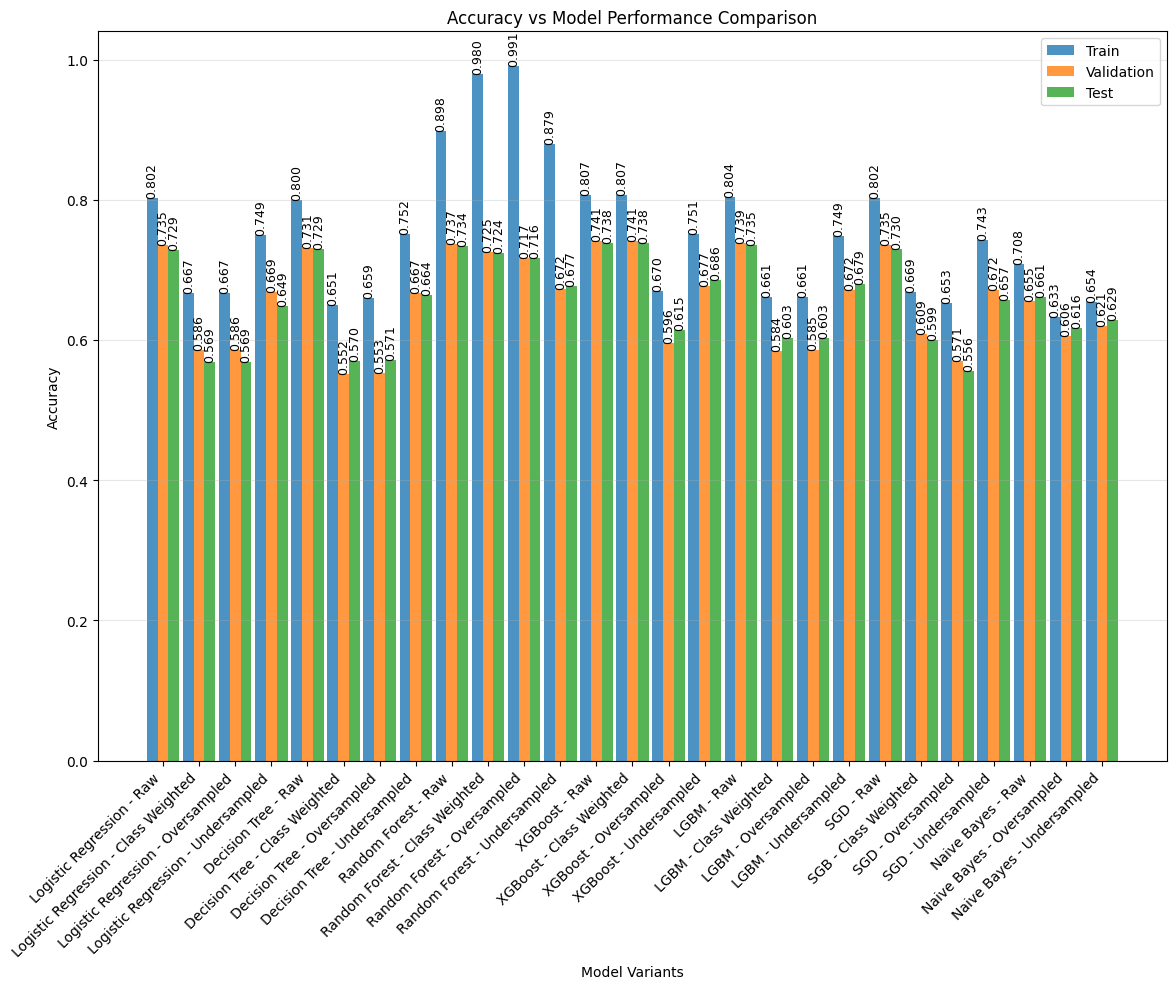

In [ ]:
results_df_acc = pd.read_csv('results/model_comparison_accuracy.csv')
plot_bar_graphs(results_df_acc, 'Accuracy')

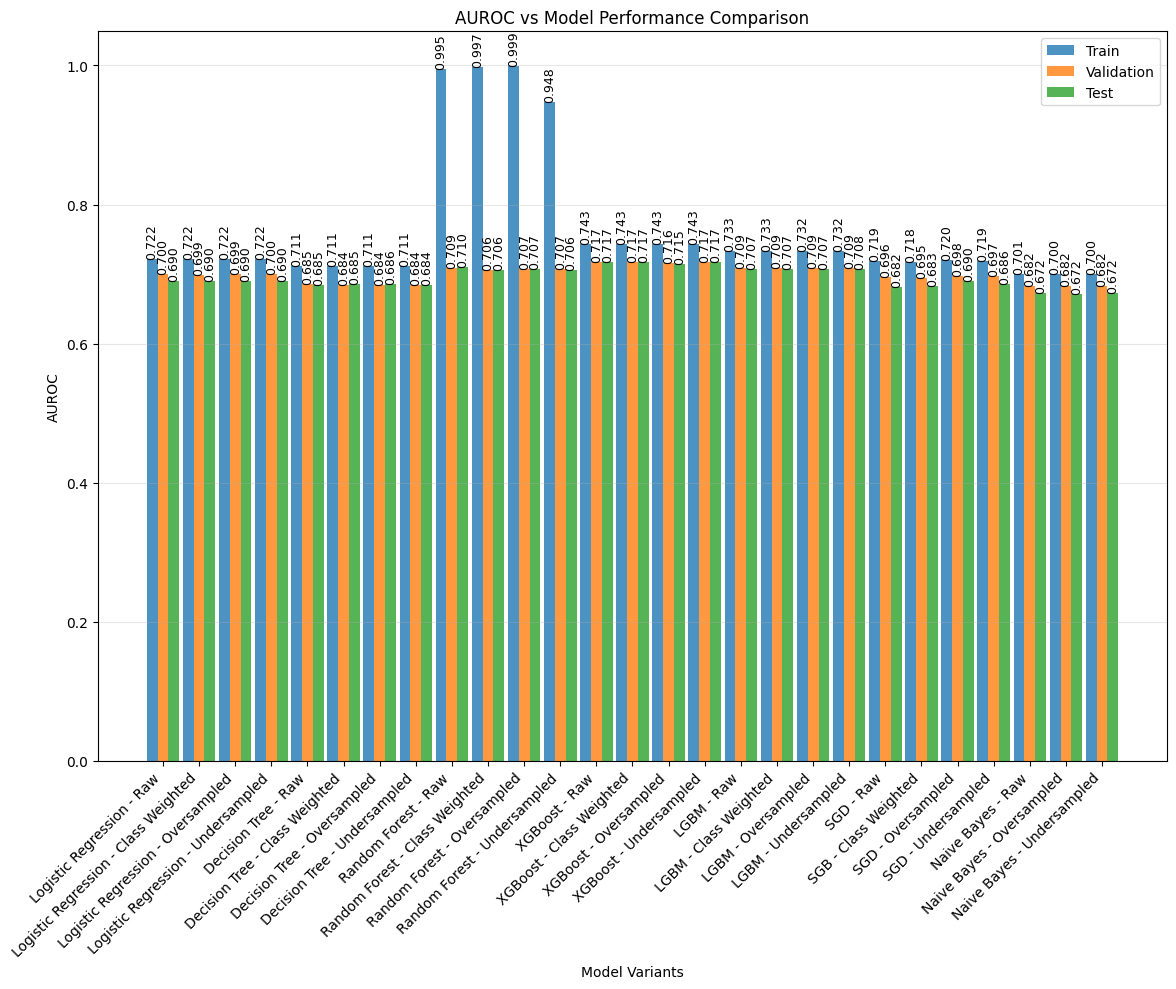

In [ ]:
results_df_auroc = pd.read_csv('results/model_comparison_auroc.csv')
plot_bar_graphs(results_df_auroc, 'AUROC')

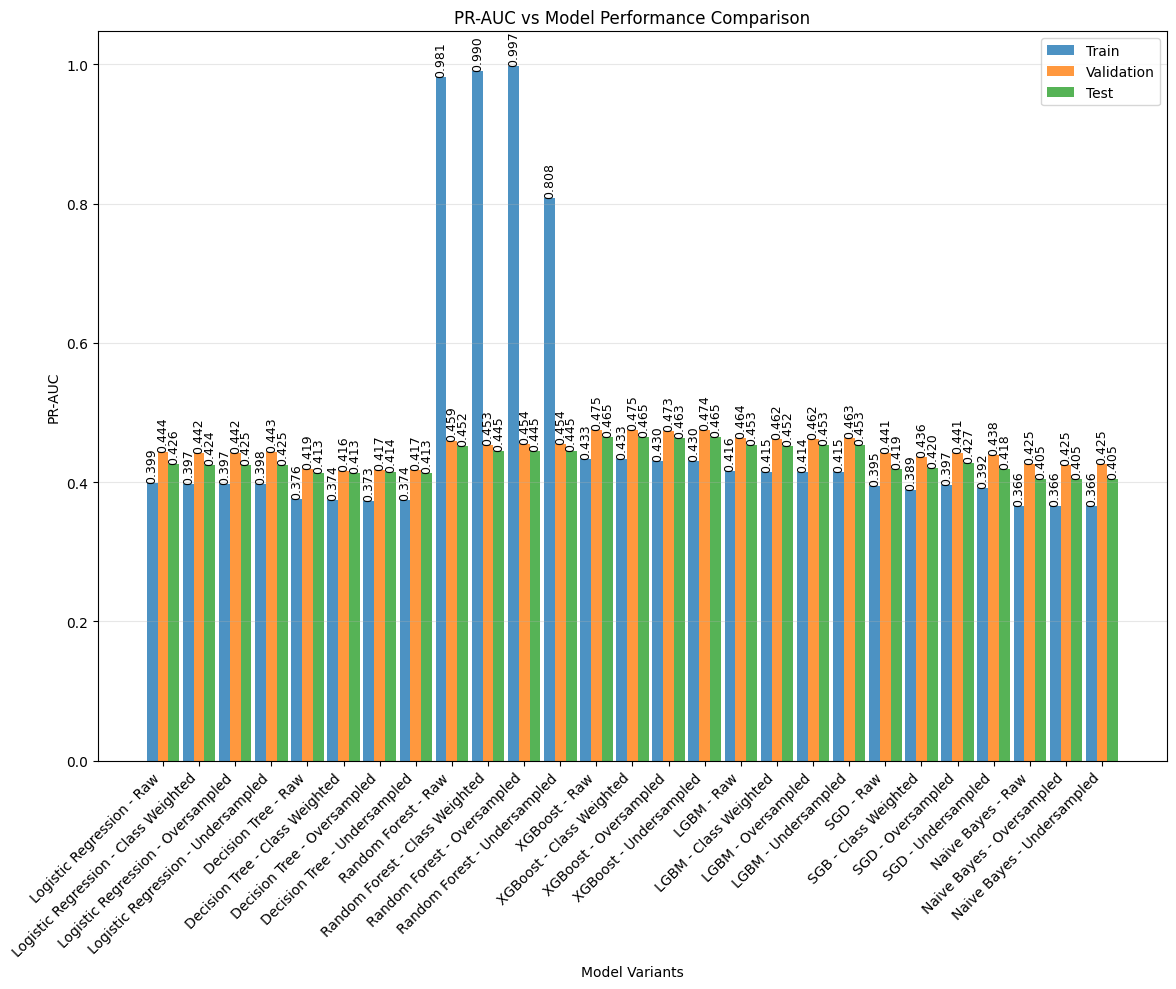

In [ ]:
results_df_prauc = pd.read_csv('results/model_comparison_prauc.csv')
plot_bar_graphs(results_df_prauc, 'PR-AUC')

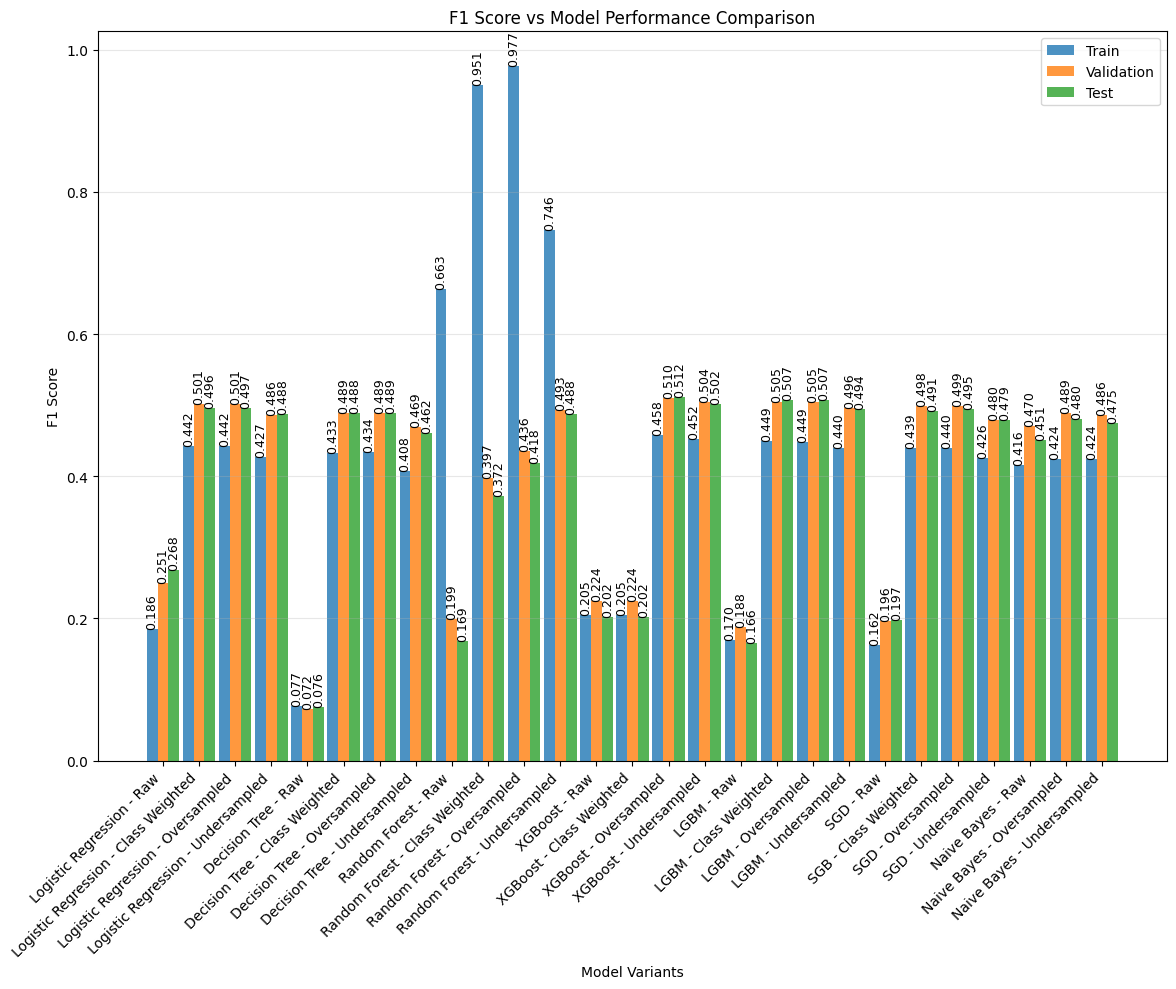

In [ ]:
results_df_f1_score = pd.read_csv('results/model_comparison_f1_score.csv')
plot_bar_graphs(results_df_f1_score, 'F1 Score')

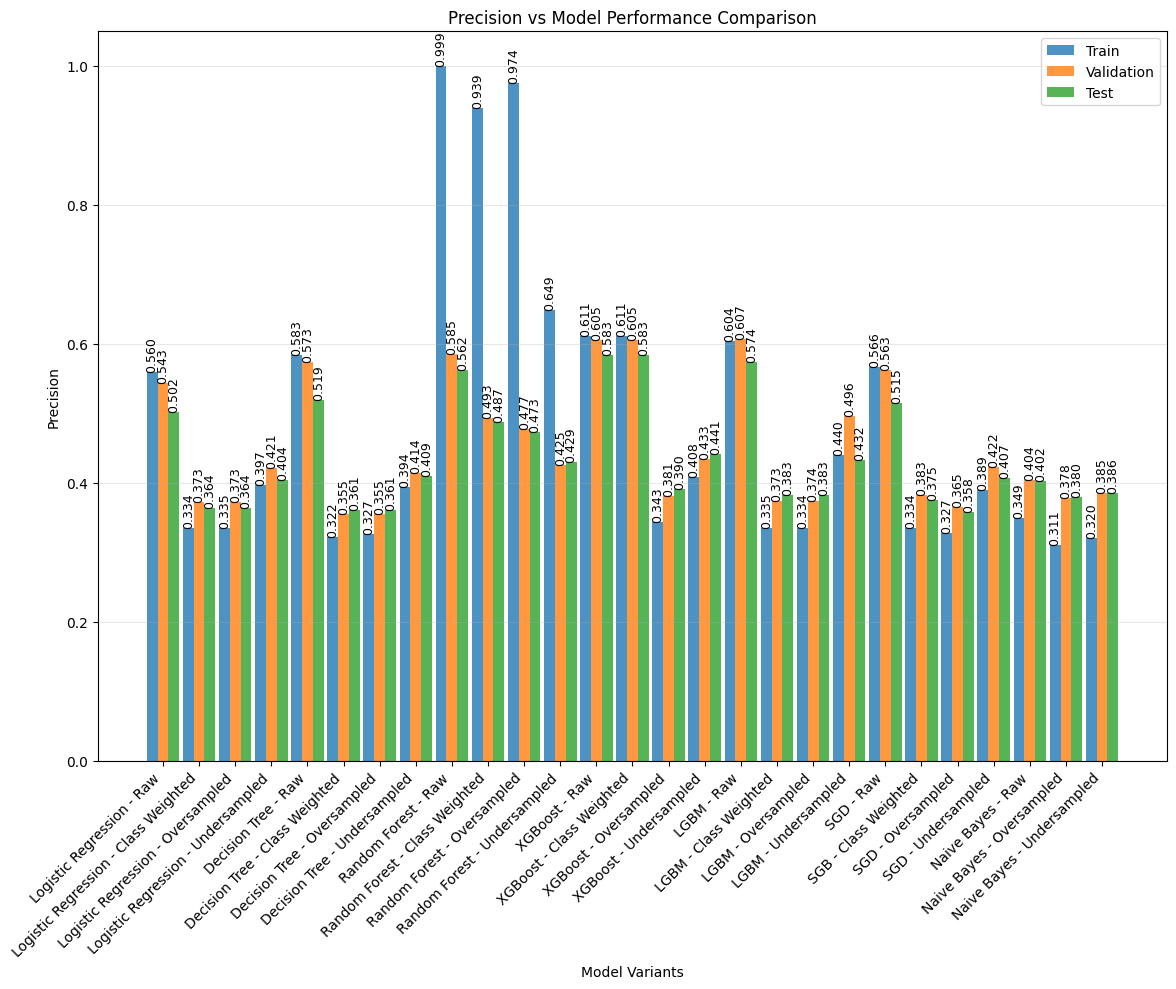

In [ ]:
results_df_precision = pd.read_csv('results/model_comparison_precision.csv')
plot_bar_graphs(results_df_precision, 'Precision')

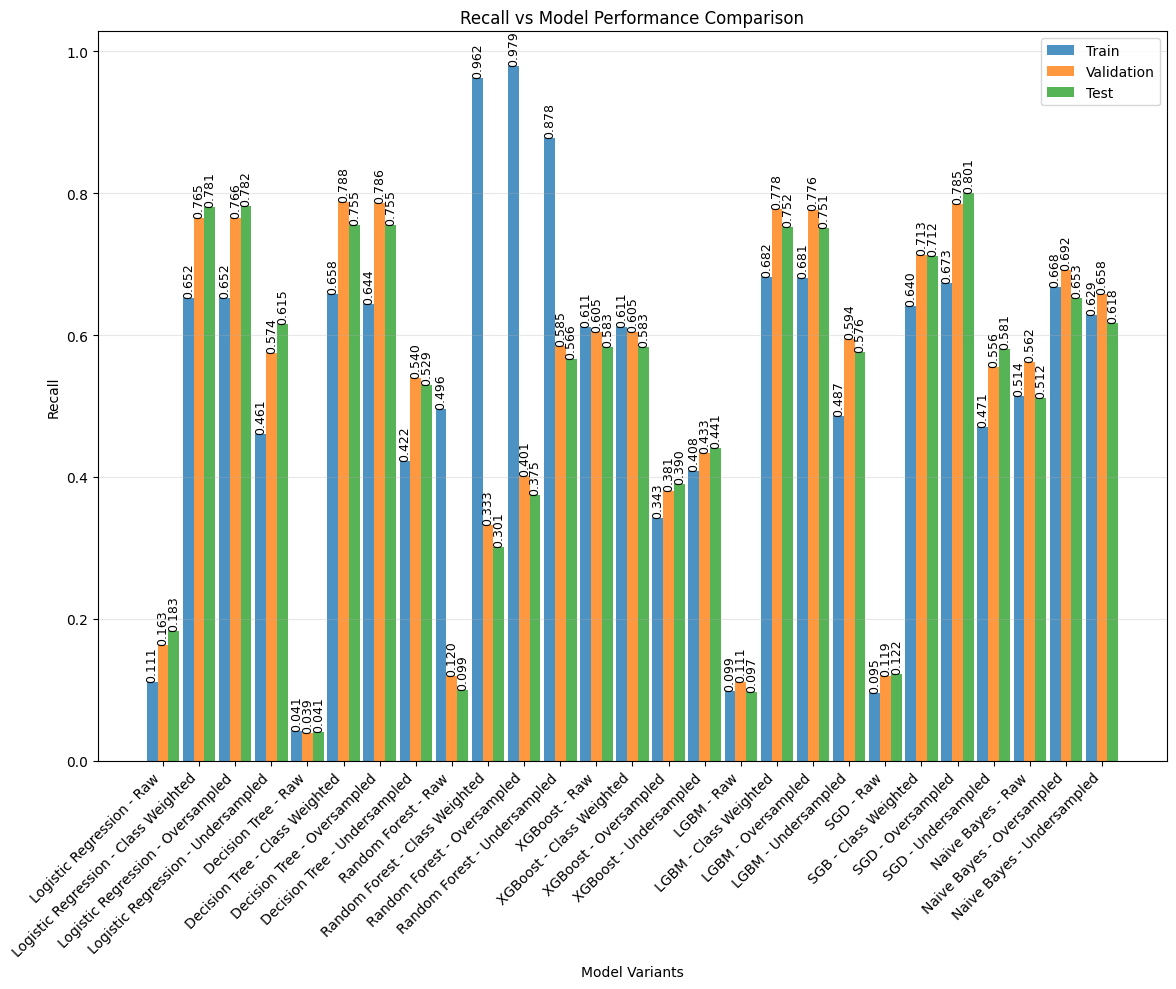

In [ ]:
results_df_recall = pd.read_csv('results/model_comparison_recall.csv')
plot_bar_graphs(results_df_recall, 'Recall')